# R laboratory exercises 06
### Laboratory session: May 5, 2021
### Exercises due on: May 23, 2021

#### Samuele Piccinelli, 2027650
#### samuele.piccinelli@studenti.unipd.it

In [1]:
# import libraries and useful dependencies
library(ggplot2)
library(latex2exp)
library(data.table)
# suppress warnings of masked objects
suppressMessages(library(purrr))
suppressMessages(library(dplyr))
suppressMessages(library(reshape2))
# plot settings
options(repr.plot.width=10, repr.plot.height=5)
theme_set(theme_bw() + theme(text=element_text(family='Times New Roman', size=12), legend.text=element_text(size=12)))

***
Some function useful for the following analysis are first defined. Mean, median and variance are calculated numerically given
- a grid of points on the $x$-axis `x`;
- the corresponding values of the distribution function `d`;
- the distance between two consecutive values `delta`.

In [2]:
get.mean <- function(x, d, delta){
    return(sum(x*d*delta))
}

get.median <- function(x, d, delta){
    integral <- cumsum(d)*delta
    last.index <- length(which(integral<=0.5))
    return(x[last.index])
}

get.variance <- function(x, d, delta){
    mean <- get.mean(x, d, delta)
    return(sum((mu-mean)**2*delta*d))
}

# find MPV
get.max = function(x, d){
    return(x[which(d>=max(d))[1]])
}

In [3]:
# prints MPV and CI given the corresponding vectors
print.estimates <- function(mu, post, ci){
    return(cat('Most probable value:\t', get.max(mu, post),
               '\n95% C.I.:\t\t [', round(ci[1],4), ', ', round(ci[2],4), ']', '\n', sep=''))
}

***

#### Exercise 1
The number of particles emitted by a radioactive source during a fixed interval of time ($\Delta t = 10s$) follows a Poisson distribution on the parameter $\mu$. The number of particles observed during consecutive time intervals is: $4$, $1$, $3$, $1$ and $3$.
1. Suppose first a uniform prior distribution and successively a Jeffrey’s prior for the parameter $\mu$. For both:
- determine and draw the posterior distribution for $\mu$, given the data;
- evaluate mean, median and variance, both analytically and numerically in _R_.
2. Evaluate a $95\%$ credibility interval for the results obtained with both priors. Compare the result with that obtained using a normal approximation for the posterior distribution, with the same mean and standard deviation.

***
For Bayes theorem, $P(\mu | \{x_k\} M)\propto f(\{x_k\} | \mu M) \cdot g(\mu|M)$, where $\{x_k\}$ indicates our measurement data set. The likelihood for a single measurement of a **Poisson process** is $$f(x|\mu)=\frac{\mu^x e^{-\mu}}{x!} \text{ with } \mu>0 \text{ and } x = 0,1,...$$; in case of multiple indipendent measurements this expression becomes $$f(\{x_k\}|\mu) = \prod^n_{k=1} f(x_k|\mu)\propto \mu^{\sum x_k} \cdot e^{-n\mu}$$ which resembles a **Gamma distribution**, $$Gamma(x|\alpha,\lambda)=kx^{\alpha-1} e^{-\lambda x}$$.

For a positive uniform prior the posterior is $Gamma(\alpha,\lambda)$ with $$\alpha=\sum_k x_k +1 \text{ and } \lambda = n$$; for a Jeffrey's prior the posterior is again a $Gamma(\alpha,\lambda)$, this time with $$\alpha=\sum_k x_k +\frac{1}{2} \text{ and } \lambda = n$$.

Since that for the Gamma distribution the median has no simple closed form, the analytical expression is not evaluated.

In [4]:
data <- c(4,1,3,1,3)

delta.mu <- 0.001; delta.t <- 10
mu <- seq(0,delta.t,delta.mu)

ci.95 <- 0.025

alpha.unif <- sum(data)+1
alpha.jeff <- sum(data)+1/2
lambda <- length(data)
n <- 1e4

In [5]:
post.unif <- dgamma(mu,alpha.unif,lambda)
post.unif.norm <- post.unif/(delta.mu*sum(post.unif))

post.jeff <- dgamma(mu,alpha.jeff,lambda)
post.jeff.norm <- post.jeff/(delta.mu*sum(post.jeff))

In [6]:
posteriors <- data.table(mu, 'Uniform'=post.unif.norm, 'Jeffrey'=post.jeff.norm)
plot.posteriors <- reshape2::melt(posteriors, id='mu') # to plot

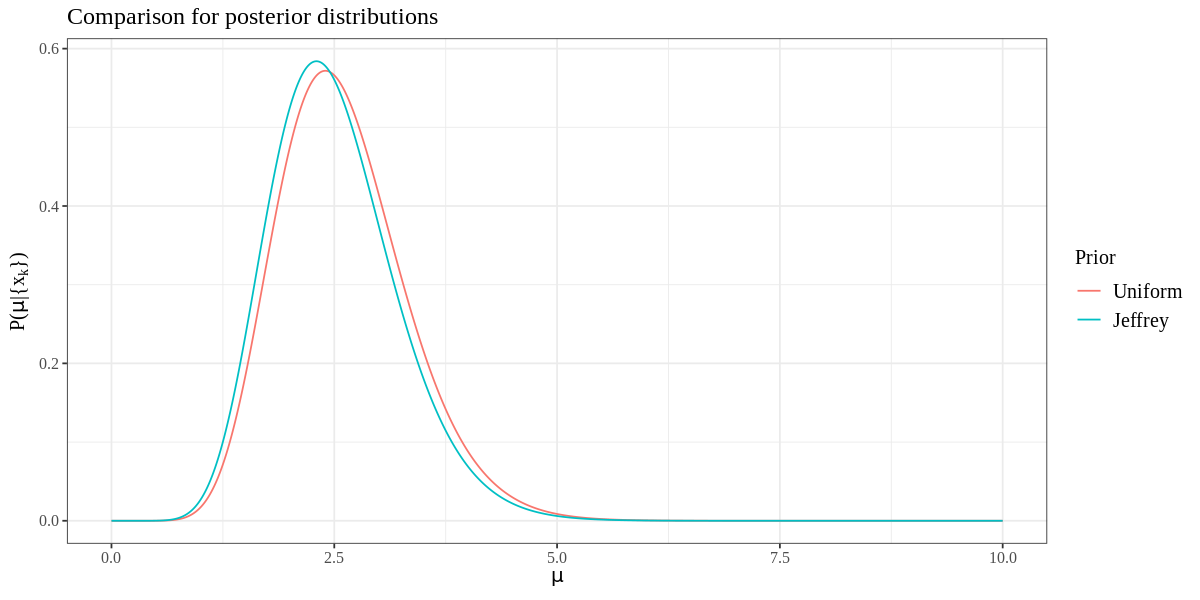

In [7]:
ggplot(plot.posteriors, aes(mu, value, col=variable)) + geom_line(size=.5) +
labs(title='Comparison for posterior distributions', x=TeX('$\\mu$'), y=TeX('$P(\\mu | \\{x_k\\})$'), col='Prior')

In [8]:
Analytical <- c(alpha.unif/lambda, '-', alpha.unif/(lambda**2))
mean.u <- get.mean(mu, post.unif.norm, delta.mu)
var.u <- get.variance(mu, post.unif.norm, delta.mu)

Numerical <- c(mean.u, get.median(mu, post.unif.norm, delta.mu), var.u)    
Estimates <- c('Mean','Median','Variance')
unif.estimates <- data.frame(Estimates, Analytical, Numerical)
cat('Estimates for uniform prior:')
unif.estimates

Estimates for uniform prior:

Estimates,Analytical,Numerical
Mean,2.6,2.600
Median,-,2.533
Variance,0.52,0.520


In [9]:
Analytical <- c(alpha.jeff/lambda, '-', alpha.jeff/(lambda**2))
mean.j <- get.mean(mu, post.jeff.norm, delta.mu)
var.j <- get.variance(mu, post.jeff.norm, delta.mu)

Numerical <- c(mean.j, get.median(mu, post.jeff.norm, delta.mu), var.j)    
Estimates <- c('Mean','Median','Variance')
jeffs.estimates <- data.frame(Estimates,Analytical,Numerical)
cat('Estimates for Jeffrey\'s prior:')
jeffs.estimates

Estimates for Jeffrey's prior:

Estimates,Analytical,Numerical
Mean,2.5,2.500
Median,-,2.433
Variance,0.5,0.500


In [10]:
ci.unif <- qgamma(c(ci.95, 1-ci.95), alpha.unif, lambda)
ci.jeff <- qgamma(c(ci.95, 1-ci.95), alpha.jeff, lambda)

cat('Uniform prior:\n')
print.estimates(mu, post.unif.norm, ci.unif)

cat('\nJeffrey\'s prior:\n')
print.estimates(mu, post.jeff.norm, ci.jeff)

Uniform prior:
Most probable value:	2.4
95% C.I.:		 [1.3844, 4.1923]

Jeffrey's prior:
Most probable value:	2.3
95% C.I.:		 [1.312, 4.0646]


In [11]:
p.norm.u <- dnorm(mu, mean=mean.u, sd=sqrt(var.u))
ci.norm.u <- qnorm(c(ci.95, 1-ci.95), mean=mean.u, sd=sqrt(var.u))

p.norm.j <- dnorm(mu, mean=mean.j, sd=sqrt(var.j))
ci.norm.j <- qnorm(c(ci.95, 1-ci.95), mean=mean.j, sd=sqrt(var.j))

cat('Uniform prior with normal approximation:\n')
print.estimates(mu, p.norm.u, ci.norm.u)

cat('\nJeffrey\'s prior with normal approximation:\n')
print.estimates(mu, p.norm.j, ci.norm.j)

Uniform prior with normal approximation:
Most probable value:	2.6
95% C.I.:		 [1.1866, 4.0134]

Jeffrey's prior with normal approximation:
Most probable value:	2.5
95% C.I.:		 [1.1141, 3.8859]


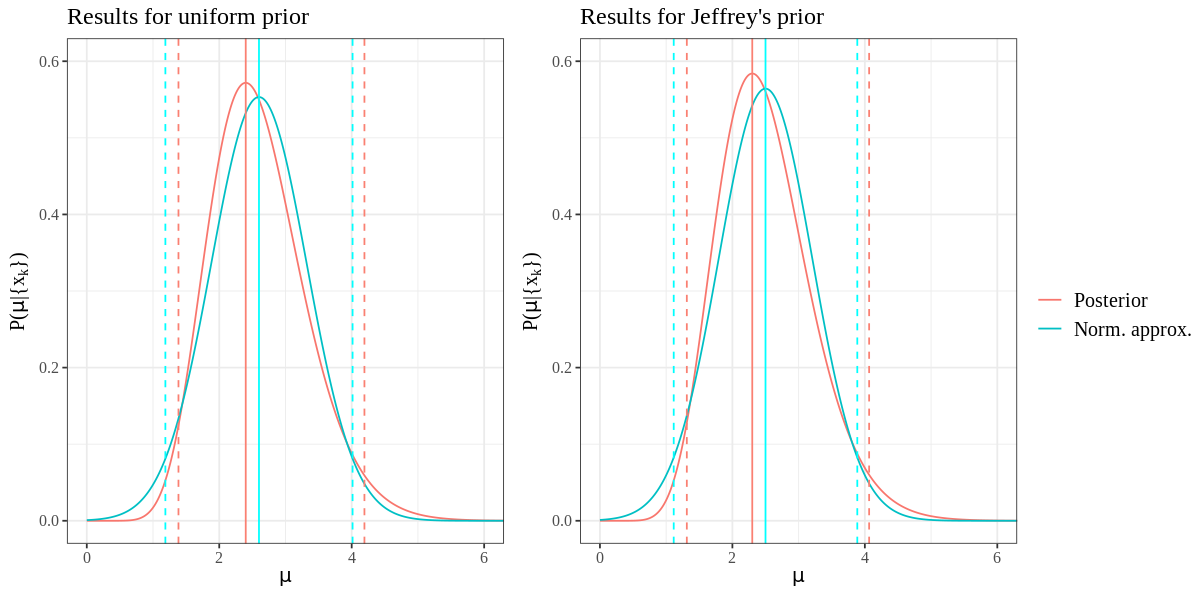

In [12]:
colors <- c(rep('salmon',3), rep('cyan',3))
linetype <- c('solid', rep('dashed',2), 'solid', rep('dashed',2))

from.uniform <- melt(data.table(mu, 'Posterior'=post.unif.norm, 'Norm. approx.'=p.norm.u), id='mu')
from.jeffrey <- melt(data.table(mu, 'Posterior'=post.jeff.norm, 'Norm. approx'=p.norm.j), id='mu')

estimates.unif <- c(get.max(mu, post.unif.norm), ci.unif[1], ci.unif[2], get.max(mu, p.norm.u), ci.norm.u[1], ci.norm.u[2])
estimates.jeff <- c(get.max(mu, post.jeff.norm), ci.jeff[1], ci.jeff[2], get.max(mu, p.norm.j), ci.norm.j[1], ci.norm.j[2])

p1 <- ggplot(from.uniform, aes(mu, value, col=variable)) + geom_line(size=.5) + coord_cartesian(xlim=c(0,6), ylim=c(0,.6)) +
            geom_vline(xintercept = estimates.unif, linetype=linetype, col = colors, size=0.5) +
            labs(title='Results for uniform prior', x=TeX('$\\mu$'), y=TeX('$P(\\mu | \\{x_k\\})$'), col='')

p2 <- ggplot(from.jeffrey, aes(mu, value, col=variable)) + geom_line(size=.5) + coord_cartesian(xlim=c(0,6), ylim=c(0,.6)) +
            geom_vline(xintercept = estimates.jeff, linetype=linetype, col = colors, size=0.5) +
            labs(title='Results for Jeffrey\'s prior', x=TeX('$\\mu$'), y=TeX('$P(\\mu | \\{x_k\\})$'), col='')

lemon::grid_arrange_shared_legend(p1, p2, ncol = 2, nrow = 1, position='right')

The $95\%$ credibility interval is showed for both distributions with the dashed lines. The difference between the posterior and the normal approximation with the same mean and standard deviation are negligible.

#### Exercise 2
Given the _Problem of the Lighthouse_ discussed last week, study the case in which both the position along the shore $\alpha$ and the distance out at sea $\beta$ are unknown.
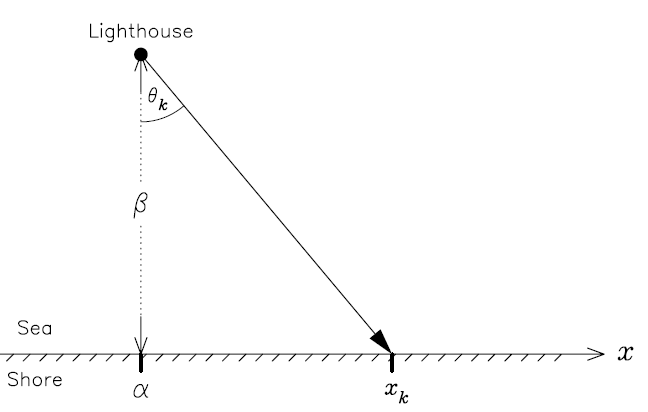

***
Since there is no reason to assume that $\alpha$ and $\beta$ are dependent, the prior can be expressed through $$P(\alpha,\beta|M)=P(\alpha|M)\cdot P(\beta|M)$$ where both $\alpha$ and $\beta$ are unknown. A uniform prior is assumed for both of them,
$$P(i)\begin{cases} 
      \frac{1}{i_{max} - i_{min}} & x\in [i_{min},i_{max}] \\
      0 & \mathrm{otherwise}
   \end{cases}
$$
for $i=\alpha,\beta$. Because of the form of the prior, the posterior probability function could be considered as the likelihood alone (in this case being the product of the probabilities for $N$ individual detections).

For the posterior: $$P(\alpha,\beta | \{x_k\},M)\propto P(\{x_k\}|\alpha,\beta,M)\cdot P(\alpha|M)\cdot P(\beta|M)$$.

The true values of $\alpha$ and $\beta$ are set to $$\alpha^*=1, \beta^*=6$$.<br>
The data $x_k$ are calculated through the expression $$x_k=\beta \tan\theta_k + \alpha$$ by using the true values $\alpha^*$ and $\beta^*$ and by generating uniformly $\theta_k$ in the interval $[-\frac{\pi}{2},\frac{\pi}{2}]$.

In [13]:
x_min <- -2; x_max <- +2
y_min <- 0; y_max <- 10
n.p <- 200

alpha <- seq(x_min, x_max, length.out=n.p)
beta  <- seq(y_min, y_max, length.out=n.p)
# area of the alpha/beta plane
dA <- ((x_max - x_min)*(y_max - y_min))/n.p**2

alpha.true <- 1; beta.true <- 6

In [14]:
# returns log of the prior
p.log.prior <- function(alpha, beta){
    logPrior <- log(dunif(alpha, min=x_min, max=x_max)) + log(dunif(beta, min=y_min, max=y_max))
    return(logPrior)
}
# returns log of the likelihood
p.log.like <- function(data, alpha, beta){
    logL <- 0.
    for (x in data){
        logL <- logL + log((beta/pi)/(beta**2 + (x-alpha)**2))
    }
    return(logL)
}
# returns log of the posterior
p.log.post <- function(alpha, beta, data){
    logPost <- p.log.like(data, alpha, beta) + p.log.prior(alpha, beta)
    return(logPost)
}

Here the functions `outer` and `partial` are used. The first allows to map a function over $>1$ vectors, while the latter builds a partial function application i.e. modifies a function by pre-filling some of its arguments. This allows to define `p.log.post` over the generated data from $\alpha^*$ and $\beta^*$ and to iterate over the grid of $\alpha$ and $\beta$ values.

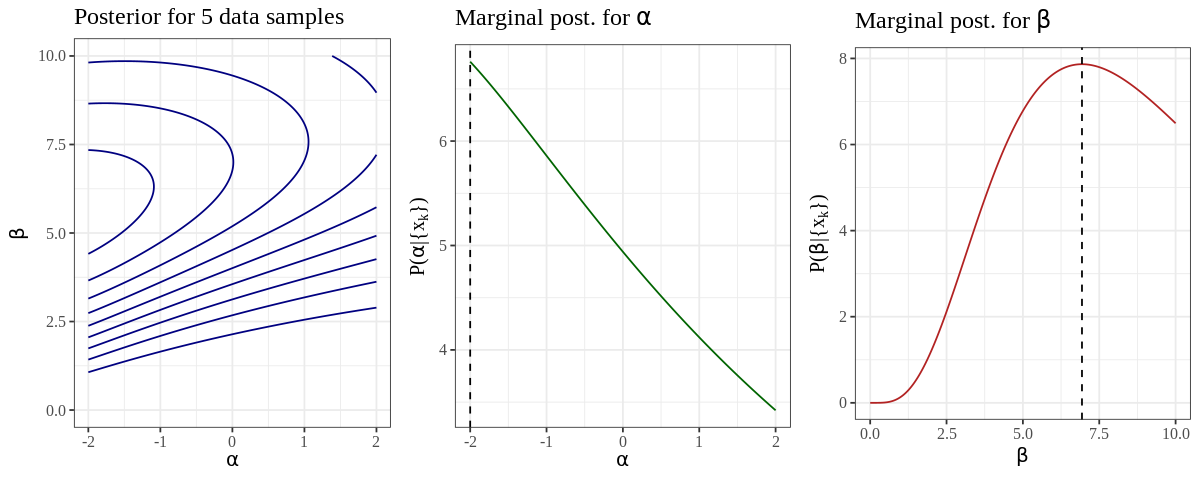

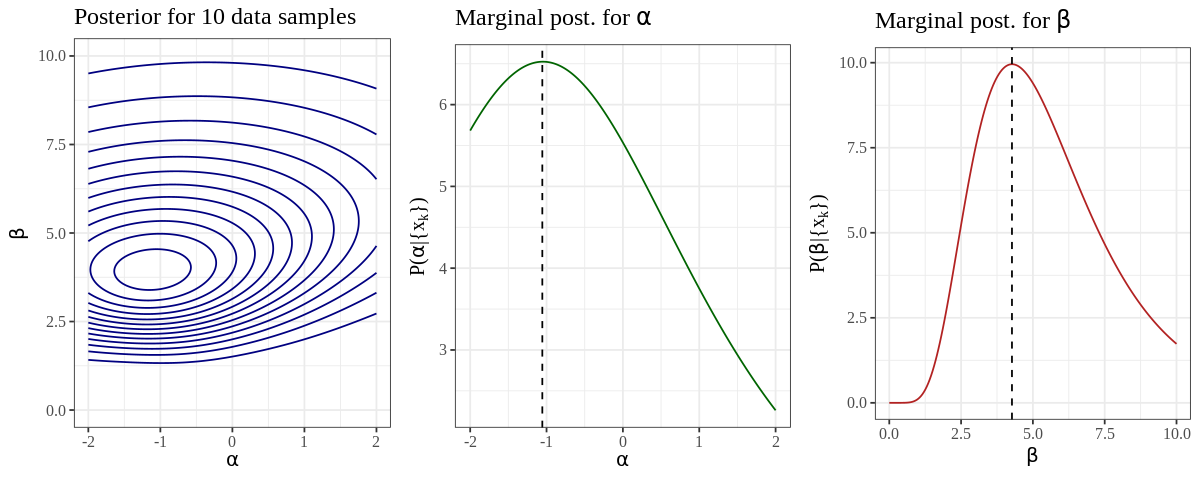

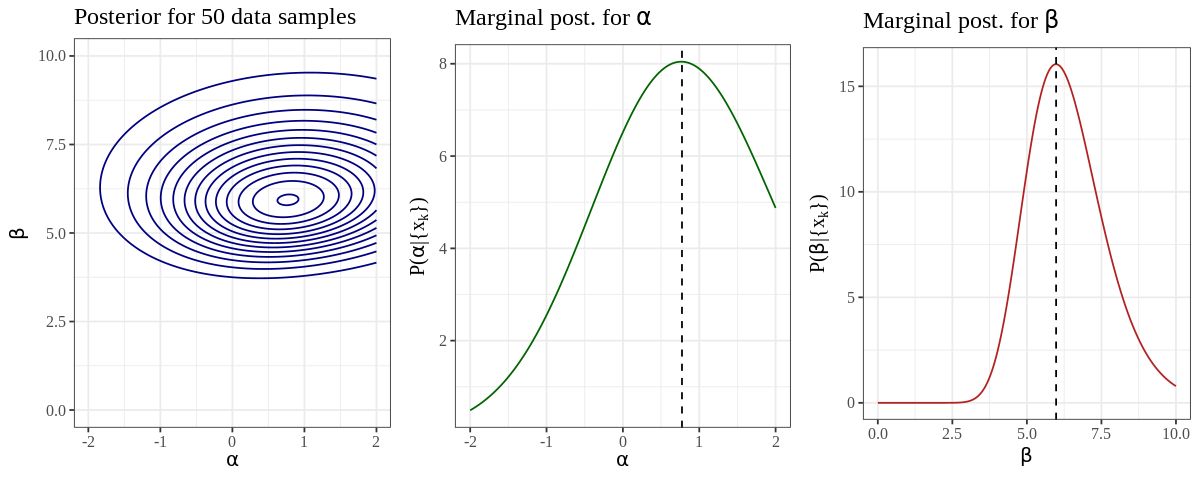

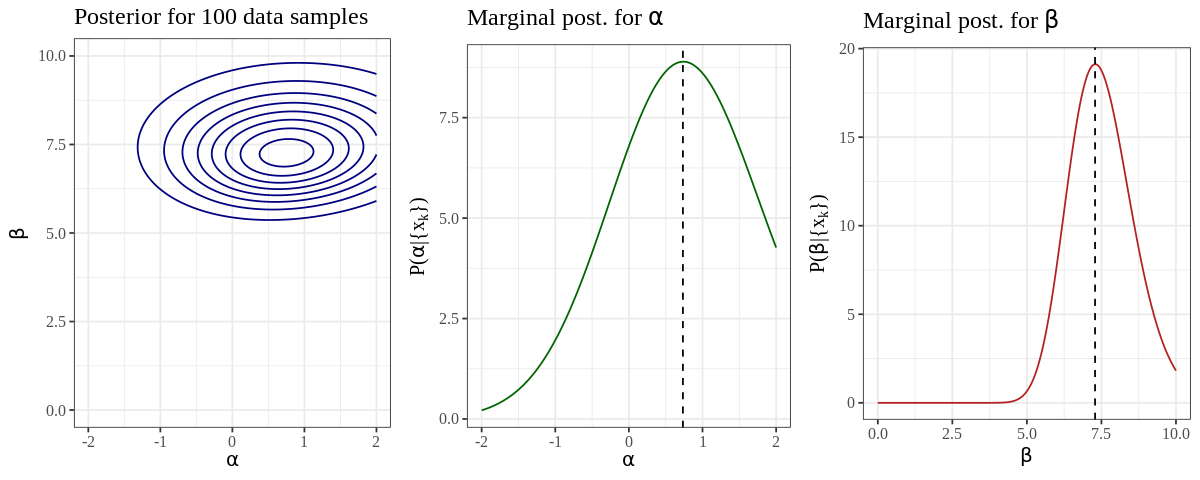

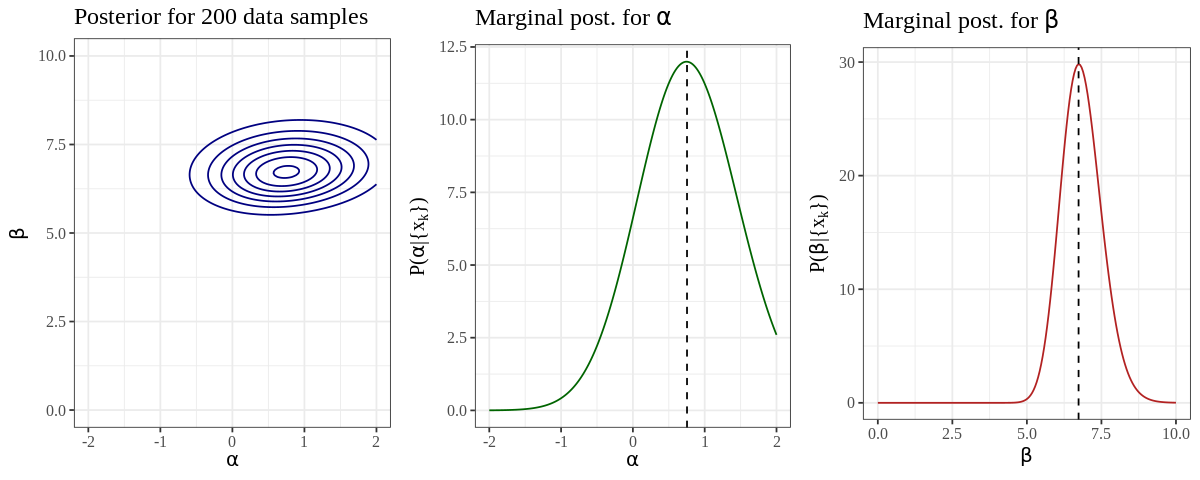

In [15]:
collected.data <- c(5, 10, 50, 100, 200)
options(repr.plot.width=10, repr.plot.height=4)

for (n.data in collected.data){
    # - Set random seed
    set.seed(2027650)
    # - Generate data from theta_k randomly sampled in [-pi/2,+pi/2]
    theta.k <- runif(n.data, min=-pi/2, max=pi/2)
    data <- beta.true*tan(theta.k)+alpha.true
    # - Compute normalized posterior
    p.post <- outer(alpha, beta, partial(p.log.post, data=data))
    p.post <- p.post - max(p.post)
    p.post.n <- exp(p.post)/(dA*sum(exp(p.post)))
    rownames(p.post.n) <- alpha; colnames(p.post.n) <- beta
    # - Compute marginalized posterior over alpha
    mar.alpha <- apply(p.post.n, 1, sum)
    mar.alpha.n <- mar.alpha/(dA*sum(mar.alpha))
    max.mar.alpha <- get.max(alpha, mar.alpha.n)
    df.alpha <- data.table(alpha, mar.alpha.n)
    # - Compute marginalized posterior over beta
    mar.beta <- apply(p.post.n, 2, sum)
    mar.beta.n <- mar.beta/(dA*sum(mar.beta))
    max.mar.beta <- get.max(beta, mar.beta.n)
    df.beta <- data.table(beta, mar.beta.n)
    # - Reshape matrix and plot results
    m.melt <- melt(p.post.n); names(m.melt) <- c('alpha','beta','z')
    
    p1 <- ggplot(m.melt, aes(x = alpha, y = beta, z = z)) + geom_contour(color='navy') +
    coord_cartesian(xlim=c(x_min,x_max), ylim=c(y_min,y_max)) +
    labs(title=paste('Posterior for',n.data,'data samples'), x=TeX('$\\alpha$'), y=TeX('$\\beta$'))
    
    p2 <- ggplot(df.alpha, aes(alpha, mar.alpha.n)) + geom_line(size=.5, col='darkgreen') +
    geom_vline(xintercept = max.mar.alpha, linetype='dashed', col = 'black', size=0.5) +
    labs(title=TeX('Marginal post. for $\\alpha$'), x=TeX('$\\alpha'), y=TeX('$P(\\alpha | \\{x_k\\})$'))
    
    p3 <- ggplot(df.beta, aes(beta, mar.beta.n)) + geom_line(size=.5, col='firebrick') +
    geom_vline(xintercept = max.mar.beta, linetype='dashed', col = 'black', size=0.5) +
    labs(title=TeX('Marginal post. for $\\beta$'), x=TeX('$\\beta'), y=TeX('$P(\\beta | \\{x_k\\})$'))
    
    gridExtra::grid.arrange(p1, p2, p3, ncol = 3, nrow = 1) 
}

As expected, the curve for $\alpha$ and $\beta$ becomes narrower as the data size increases since $FWHM\propto 1/\sqrt{N}$, with $N$ being the number of data samples.

#### Exercise 3
Given the _Signal over Background_ example discussed last week, analyze and discuss the following cases:
1. Vary the sampling resolution used to generate the data, keeping the same sampling range `xdat <- seq(from=-7*w, to=7*w, by=0.5*w)`:
- change the resolution $w = \{0.1, 0.25, 1, 2, 3\}$;
- check the effect on the results.
2. Change the ratio $A/B$ used to simulate the data (keeping both positive in accordance with the prior) and check the effect on the results.

In [16]:
# Generative model
signal <- function(x, A, B, x0, w, dt){
    return(dt*(A*exp(-(x-x0)**2/(2*w**2)) + B))
}

# Log posterior
log.post <- function(d, x, A, B, x0, w, dt) {
    if(A<0 || B<0){
        return(-Inf)
    } # the effect of the prior
    sum(dpois(d, lambda=signal(x, A, B, x0, w, dt), log=TRUE))
}

In [17]:
# Define model parameters
x0     <- 0 # Signal peak
w      <- 1 # Signal width
A.true <- 2 # Signal amplitude
B.true <- 1 # Background amplitude
dt     <- 5 # Exposure time

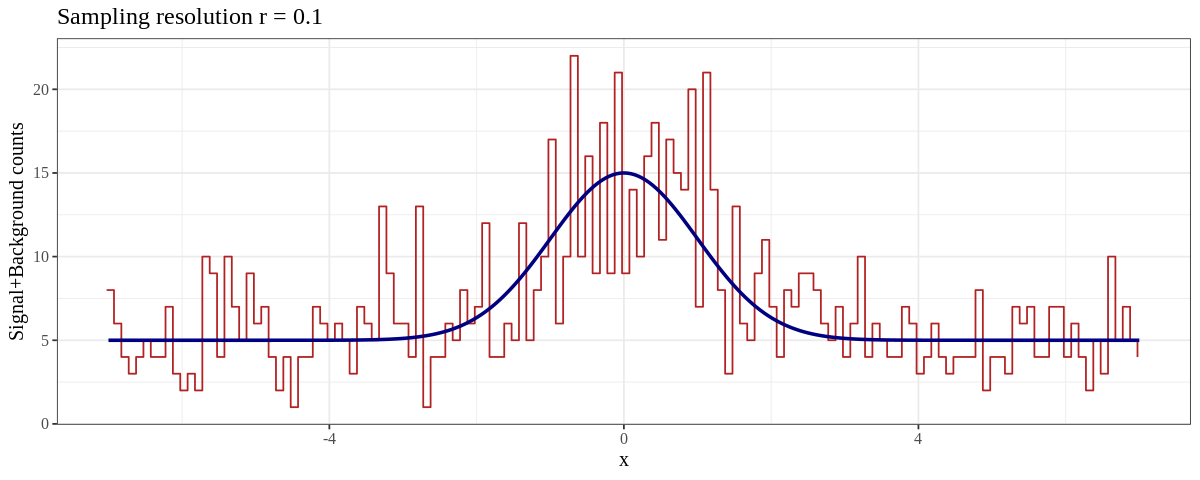

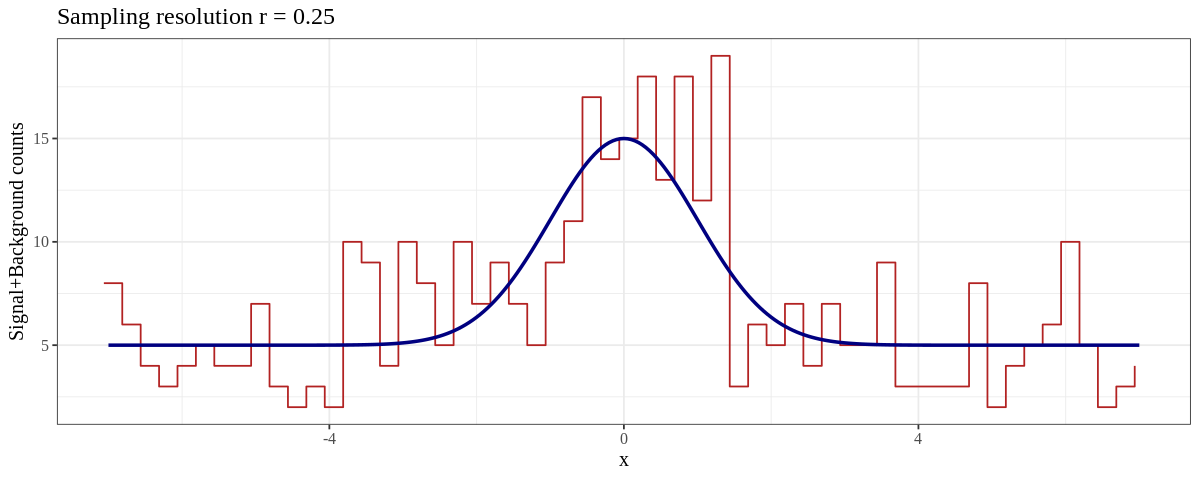

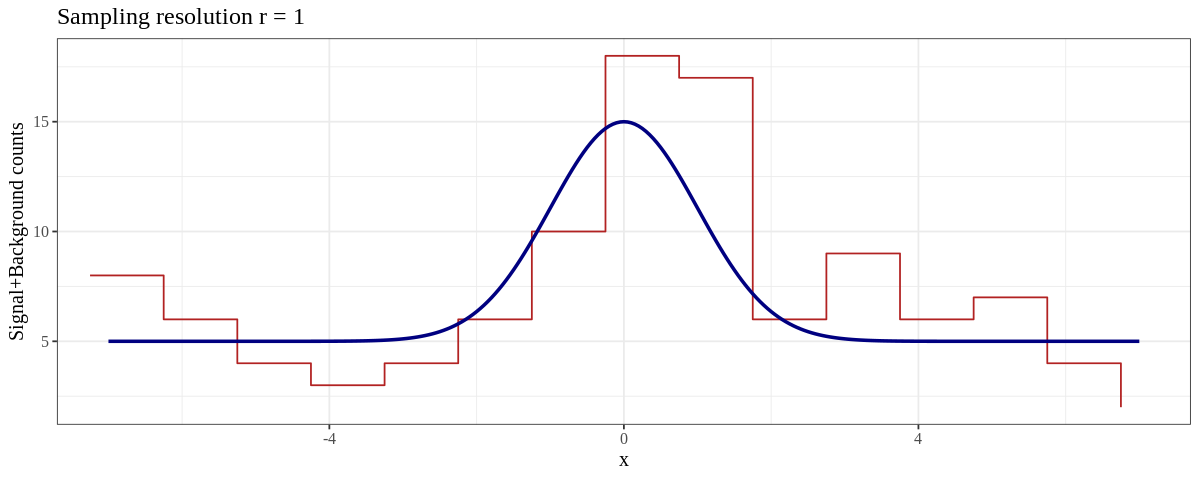

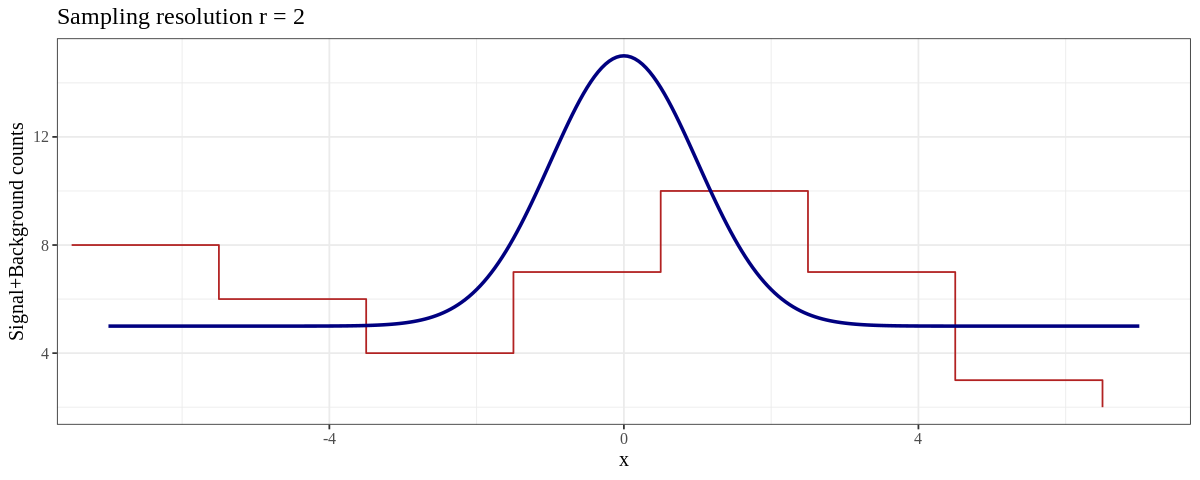

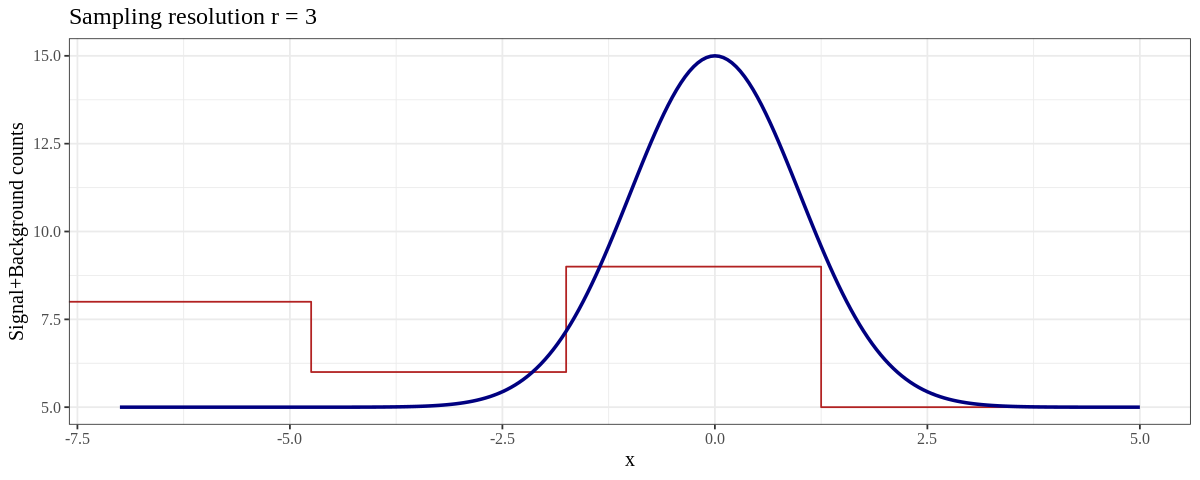

In [18]:
# vector of the sampling resolutions
sr <- c(.1,.25,1,2,3)

for (r in sr){
    set.seed(2027650)
    xdata  <- seq(from=-7*w, to=7*w, by=r*w)
    s.true <- signal(xdata, A.true, B.true, x0, w, dt)
    ddata  <- rpois(length(s.true), s.true)
    
    xplot <- seq(from=min(xdata), to=max(xdata), by=0.05*w)
    splot <- signal(xplot, A.true, B.true, x0, w, dt)
    xdata.off <- xdata - 0.25*r
    
    curve <- data.table(xplot, splot); sbcounts <- data.table(xdata.off, ddata)
    
    print(ggplot(data=sbcounts, aes(x=xdata.off, y=ddata, group=1)) + geom_step(color='firebrick') +
    geom_line(data=curve, aes(x=xplot, y=splot, group=1), color='navy', size=1) +
    coord_cartesian(xlim=range(xplot), ylim=range(c(splot, ddata))) +
    labs(title=paste('Sampling resolution r =',r), x='x', y='Signal+Background counts'))
}

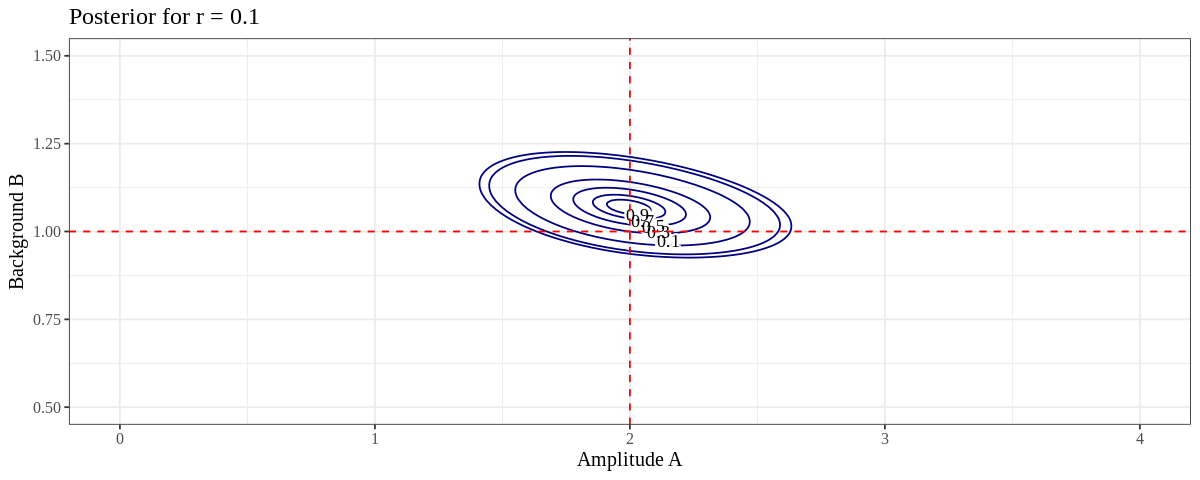

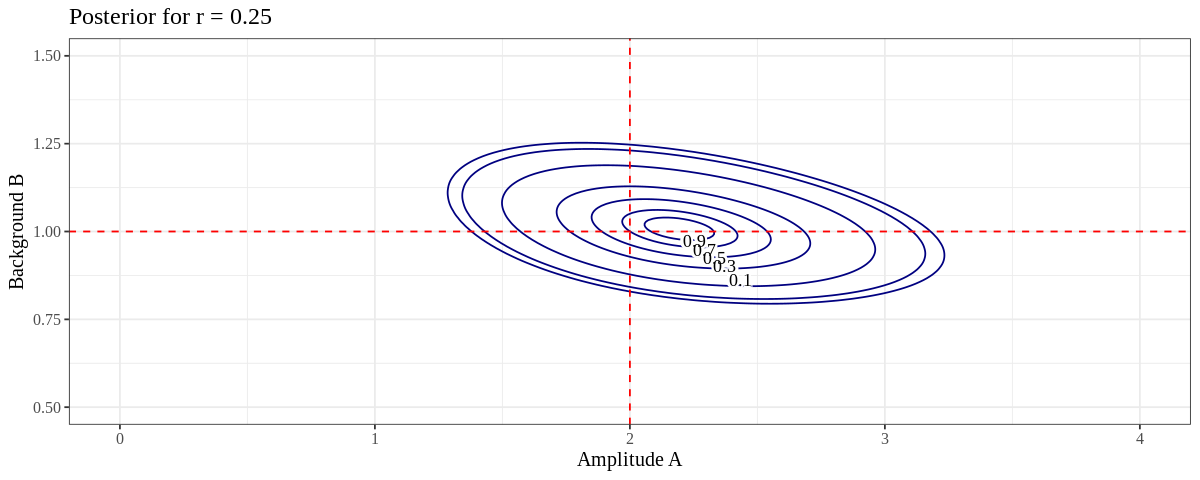

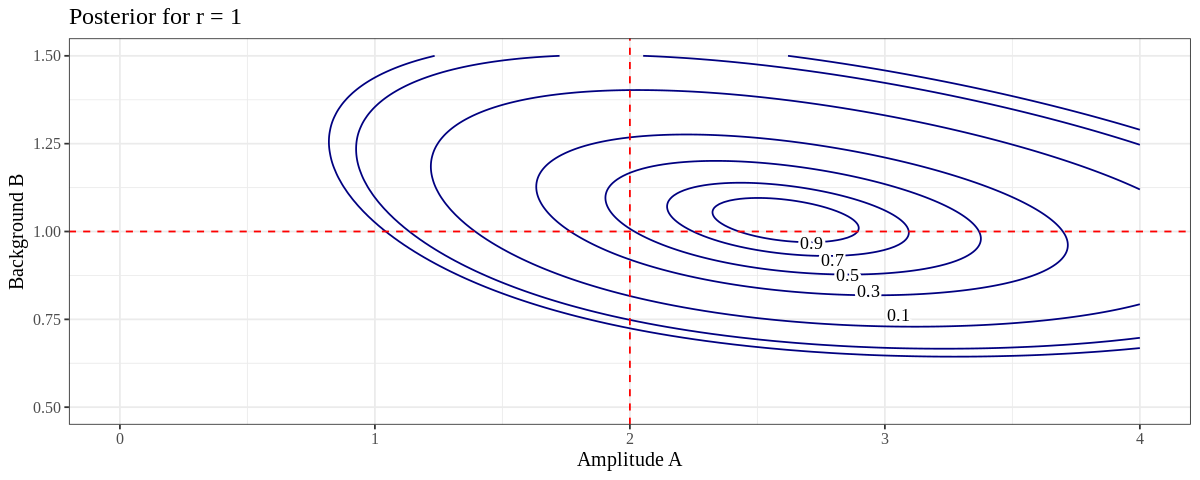

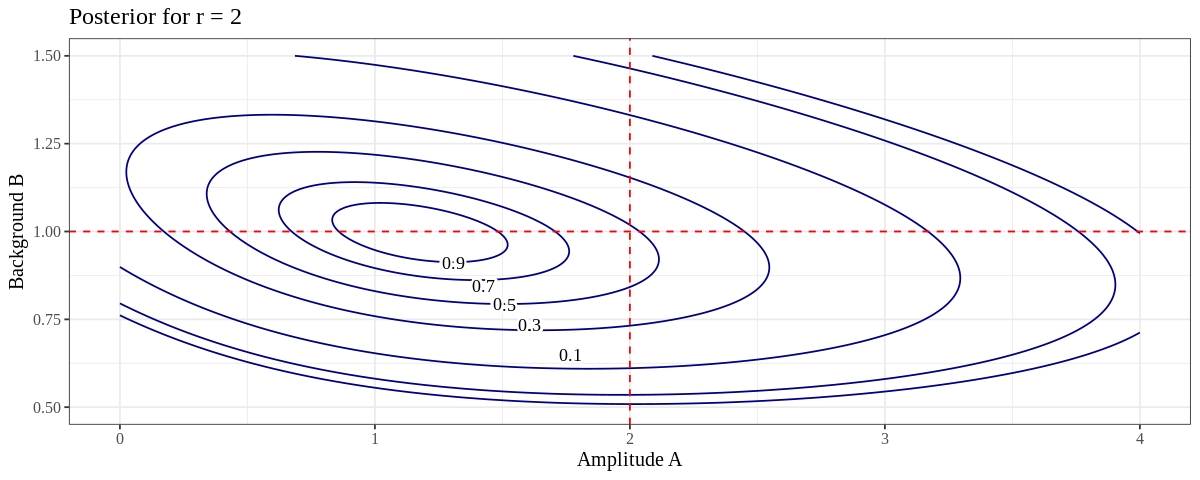

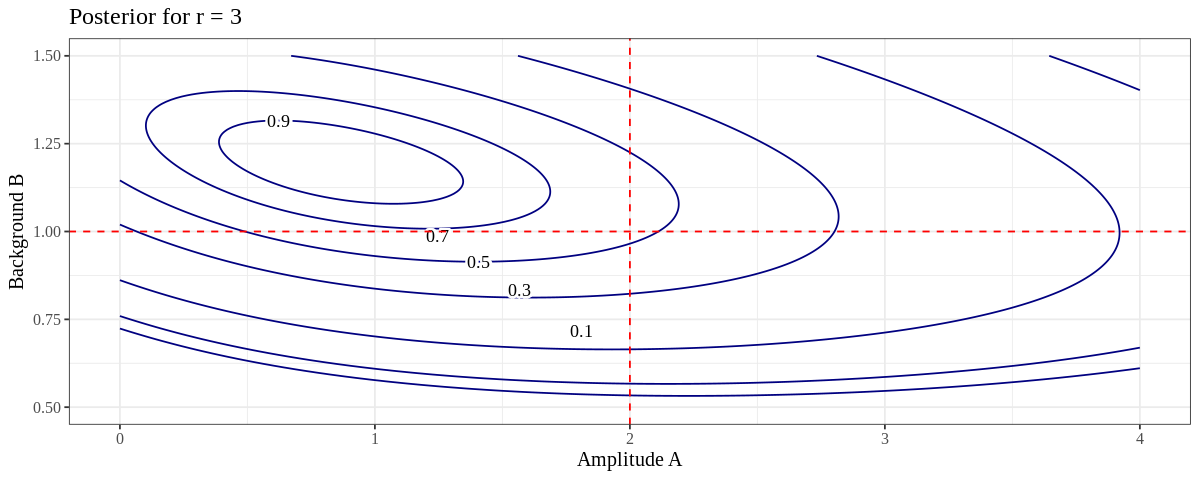

In [19]:
Nsamp <- 200
A <- seq(0.0, 4.0, length.out=Nsamp)
B <- seq(0.5, 1.5, length.out=Nsamp)

for (r in sr){
    set.seed(2027650)
    xdata  <- seq(from=-7*w, to=7*w, by=r*w)
    s.true <- signal(xdata , A.true, B.true , x0, w, dt)
    ddata  <- rpois(length(s.true), s.true)
    
    # Compute log unnormalized posterior , z = ln P*(a,b|D), on a regular grid
    z <- matrix(data=NA , nrow=length(A), ncol=length(B))
    for(j in 1:length(A)) {
        for(k in 1:length(B)) {
            z[j,k] <- log.post(ddata, xdata, A[j], B[k], x0, w, dt)
        }
    }
    z <- z - max(z) # set maximum to zero
    
    rownames(z) <- A; colnames(z) <- B
    posterior.2d <- melt(exp(z)); names(posterior.2d) <- c('A','B','exp.z')
    breaks <- c(0.005, 0.01, 0.05, 0.25, 0.5, 0.75, 0.9, 1.0)
    
    # Plot unnormalized 2D posterior as contours
    print(ggplot(posterior.2d, aes(x = A, y = B, z = exp.z)) +
          geom_contour(color='navy', breaks=breaks) +
          metR::geom_text_contour(stroke = 0.2, family='Times New Roman') +
          coord_cartesian(xlim=c(min(A),max(A)), ylim=c(min(B),max(B))) +
          geom_vline(xintercept=A.true, linetype='dashed', col='red', size=0.5) +
          geom_hline(yintercept=B.true, linetype='dashed', col='red', size=0.5) +
          labs(title=paste('Posterior for r =',r), x='Amplitude A', y='Background B'))
}

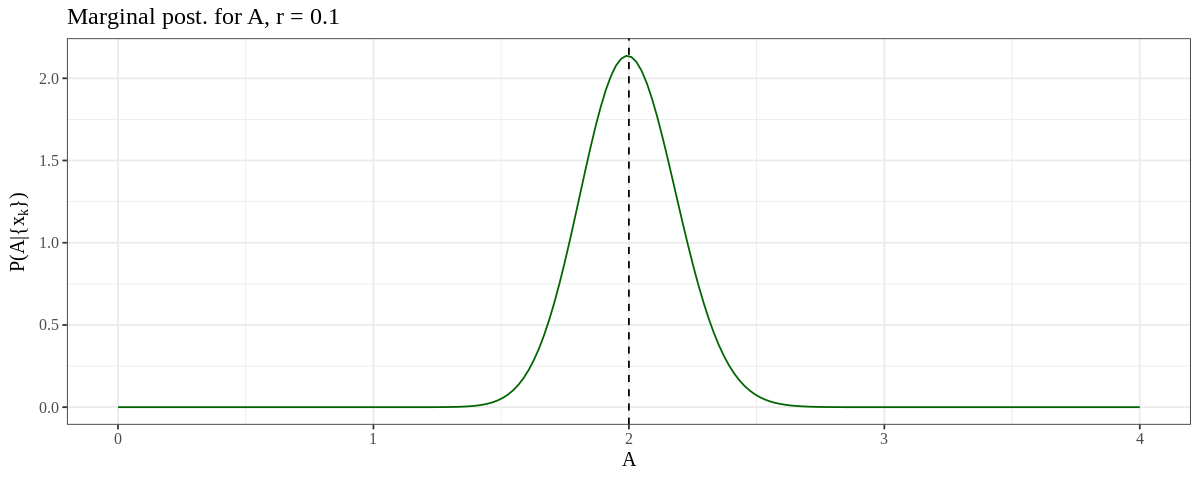

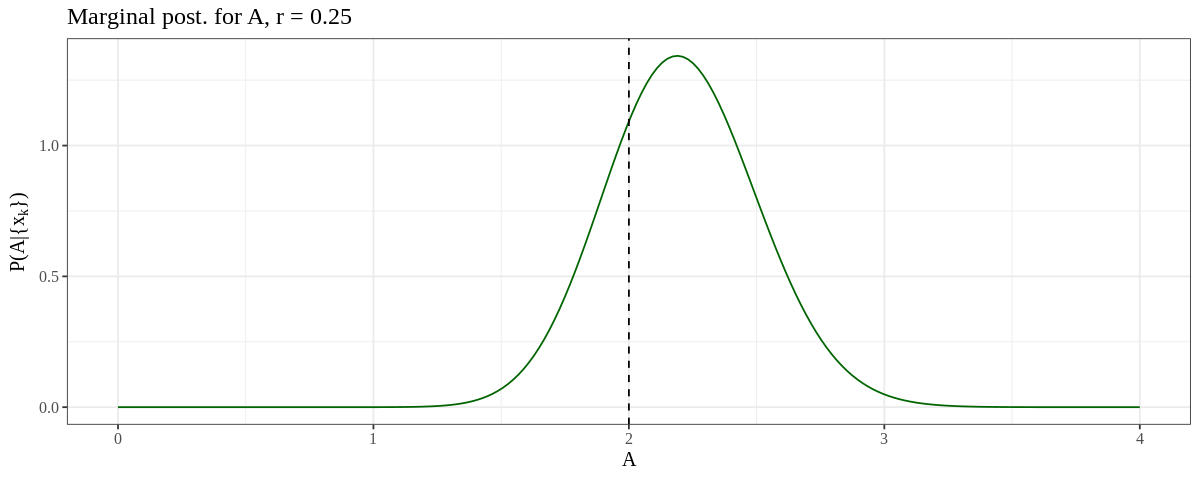

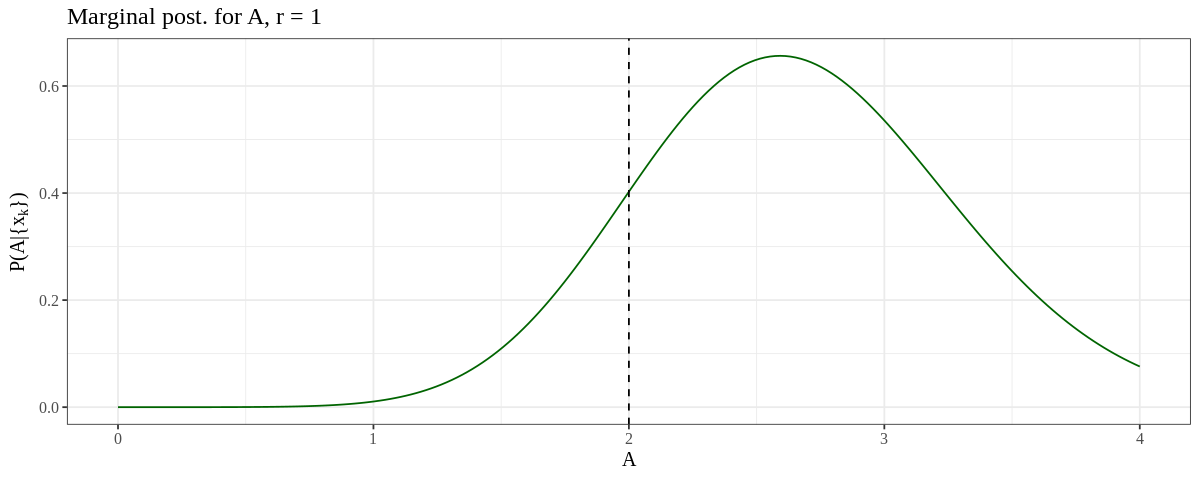

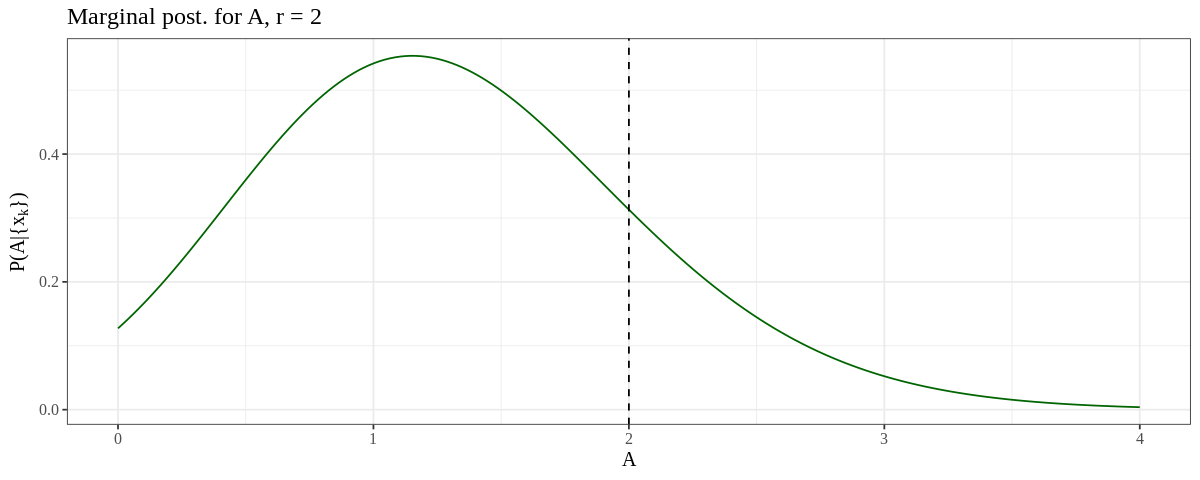

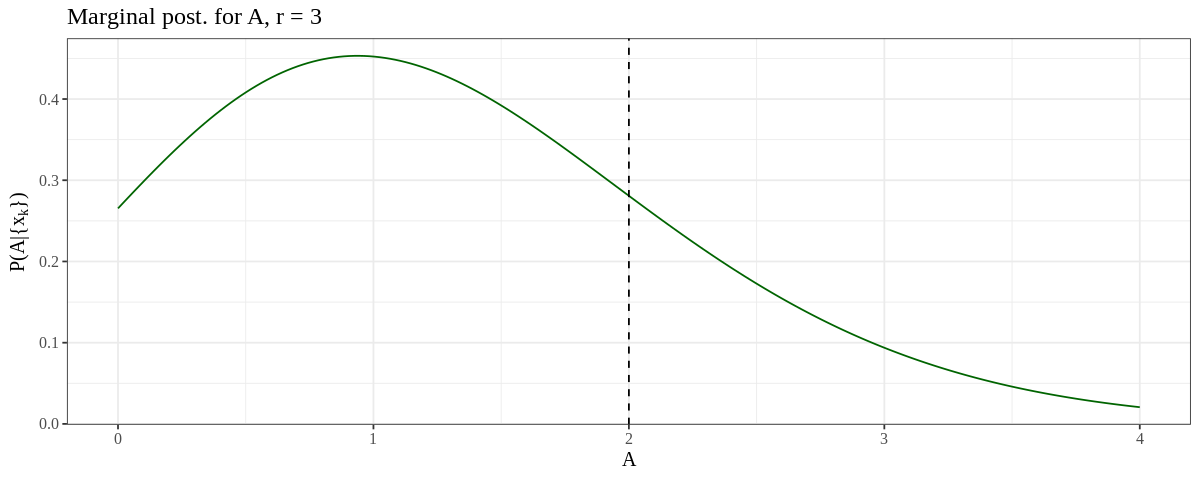

In [20]:
dA <- (max(A)-min(A))/Nsamp

for (r in sr){
    set.seed(2027650)
    xdata  <- seq(from=-7*w, to=7*w, by=r*w)
    s.true <- signal(xdata , A.true, B.true , x0, w, dt)
    ddata  <- rpois(length(s.true), s.true)
    
    # Compute log unnormalized posterior , z = ln P*(a,b|D), on a regular grid
    z <- matrix(data=NA , nrow=length(A), ncol=length(B))
    for(j in 1:length(A)) {
        for(k in 1:length(B)) {
            z[j,k] <- log.post(ddata, xdata, A[j], B[k], x0, w, dt)
        }
    }
    z <- z - max(z) # set maximum to zero

    z.a    <- apply(exp(z), 1, sum)
    z.a.n  <- z.a/(dA*sum(z.a))
    df.z.a <- data.table(A, z.a.n)
    
    # Plot normalized marginal posterior for A
    print(ggplot(df.z.a, aes(A, z.a.n)) + geom_line(size=.5, col='darkgreen') +
          geom_vline(xintercept=A.true, linetype='dashed', col='black', size=0.5) +
          labs(title=paste('Marginal post. for A, r =',r), x='A', y=TeX('$P(A | \\{x_k\\})$')))
}

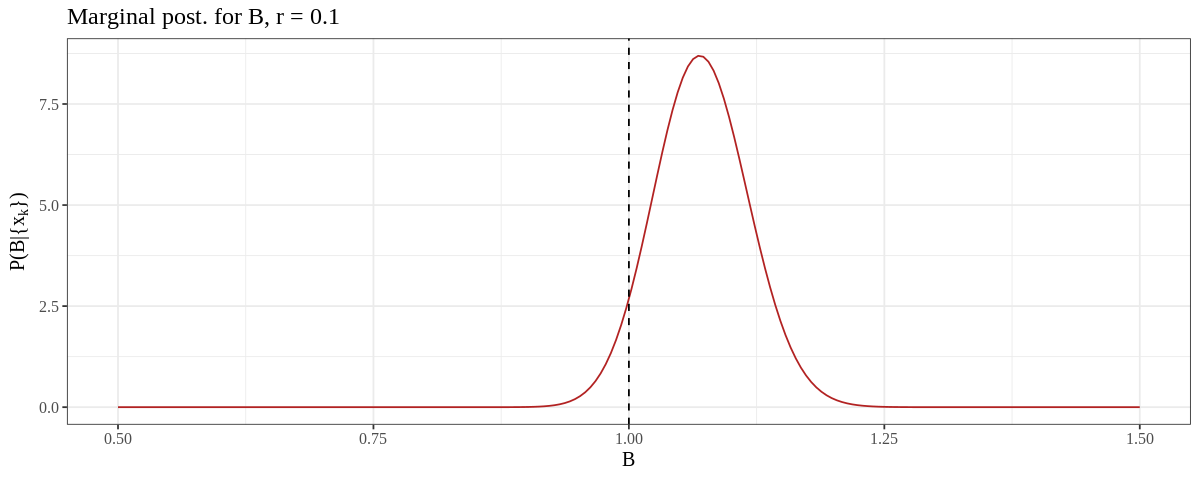

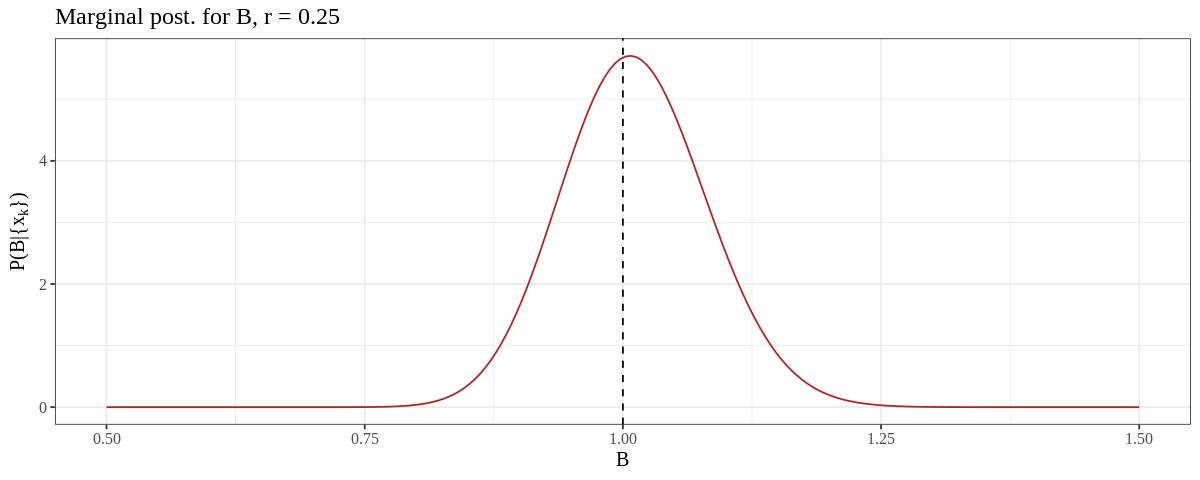

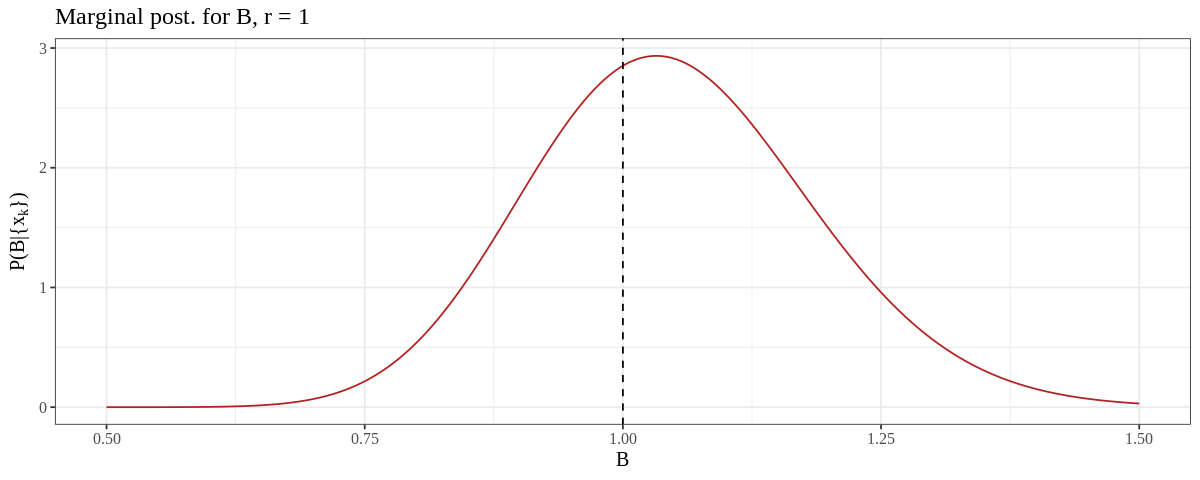

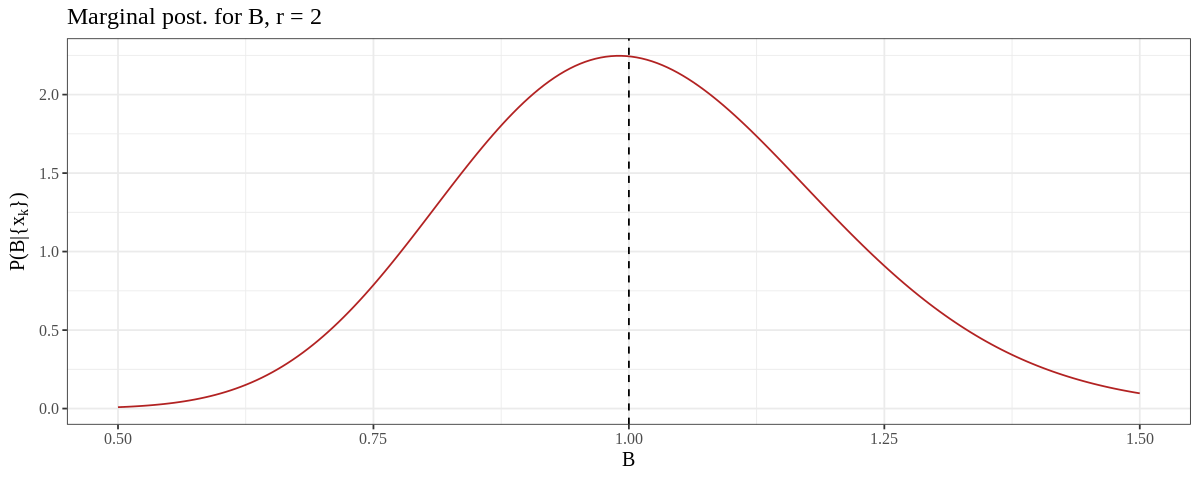

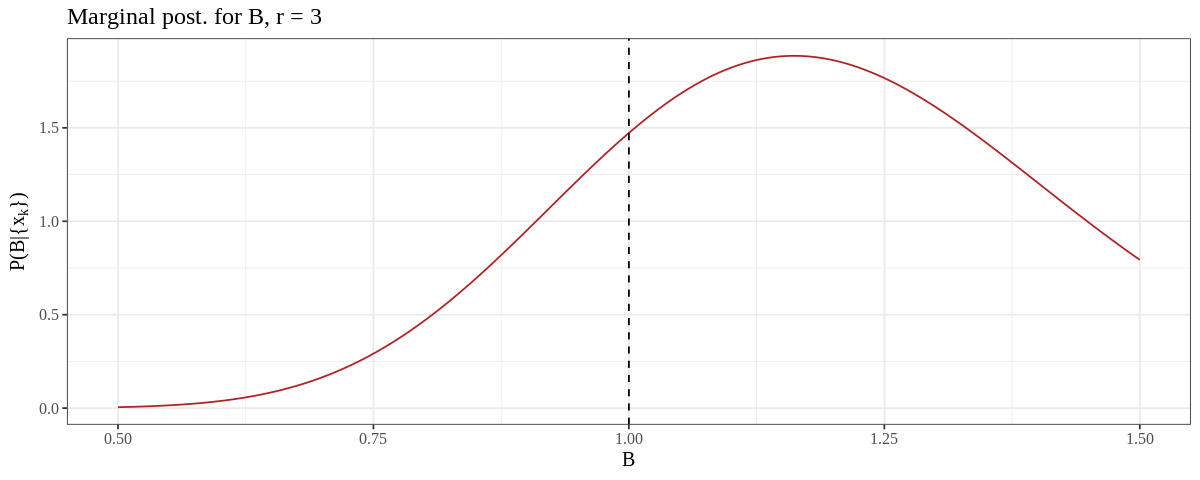

In [21]:
dB <- (max(B)-min(B))/Nsamp

for (r in sr){
    set.seed(2027650)
    xdata  <- seq(from=-7*w, to=7*w, by=r*w)
    s.true <- signal(xdata , A.true, B.true , x0, w, dt)
    ddata  <- rpois(length(s.true), s.true)
    
    # Compute log unnormalized posterior , z = ln P*(a,b|D), on a regular grid
    z <- matrix(data=NA , nrow=length(A), ncol=length(B))
    for(j in 1:length(A)) {
        for(k in 1:length(B)) {
            z[j,k] <- log.post(ddata, xdata, A[j], B[k], x0, w, dt)
        }
    }
    z <- z - max(z) # set maximum to zero

    z.b    <- apply(exp(z), 2, sum)
    z.b.n  <- z.b/(dB*sum(z.b))
    df.z.b <- data.table(B, z.b.n)
    
    # Plot normalized marginal posterior for B
    print(ggplot(df.z.b, aes(B, z.b.n)) + geom_line(size=.5, col='firebrick') +
          geom_vline(xintercept=B.true, linetype='dashed', col='black', size=0.5) +
          labs(title=paste('Marginal post. for B, r =', r), x='B', y=TeX('$P(B | \\{x_k\\})$')))
}

For the second point, `B.true` (amplitude of the background) is kept constant while `A.true` (amplitude of the signal) takes different values taken from a vector `As.true`; overall the ratio $A/B$ varies for each case.

In [22]:
As.true <- c(2, 3, 4, 5, 10, 15, 20, 25)

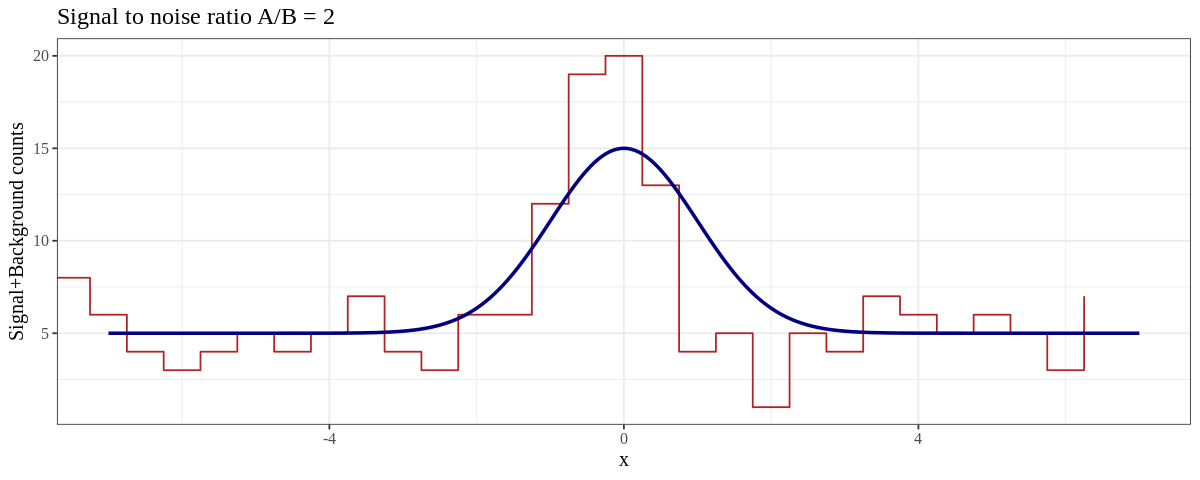

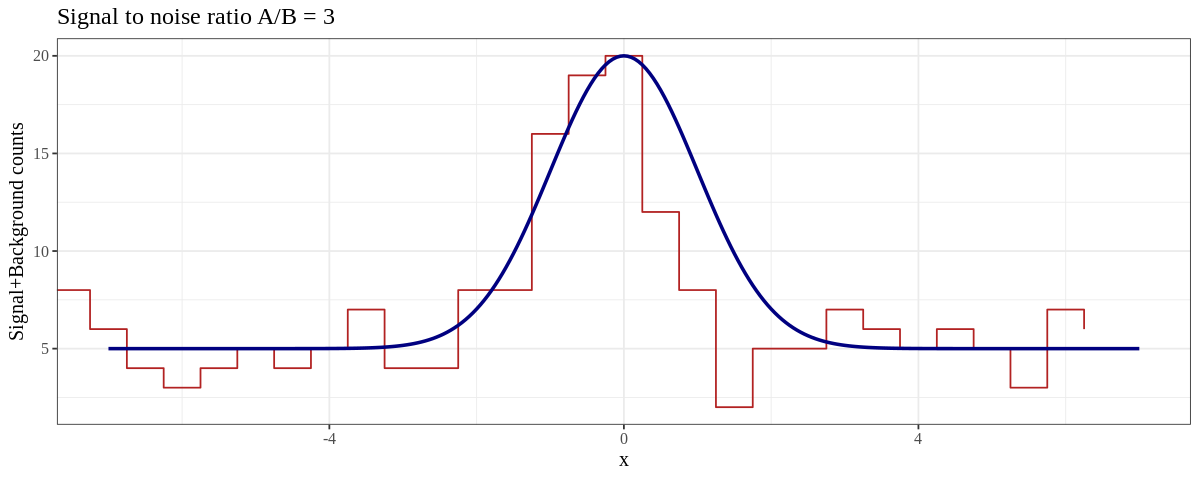

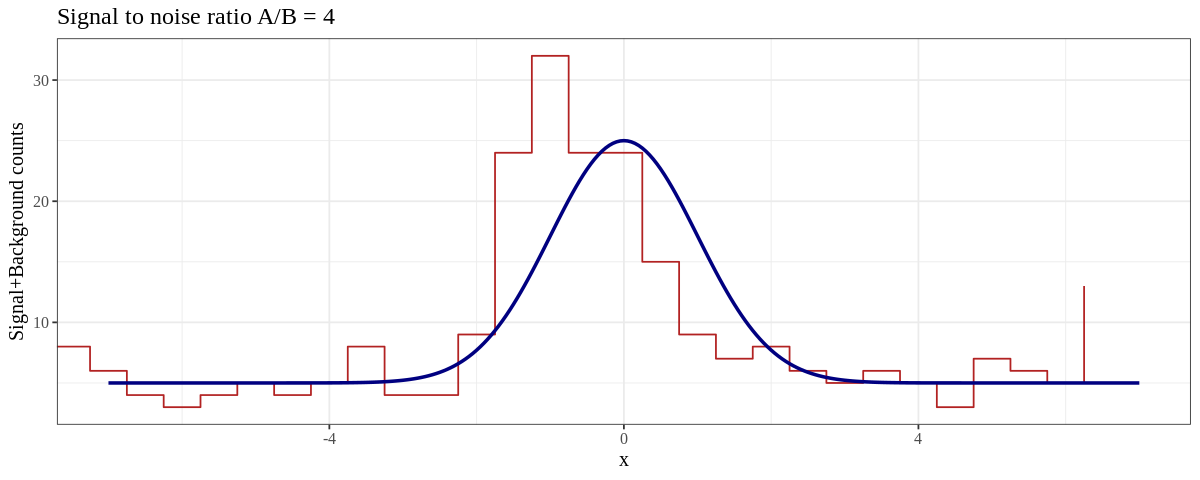

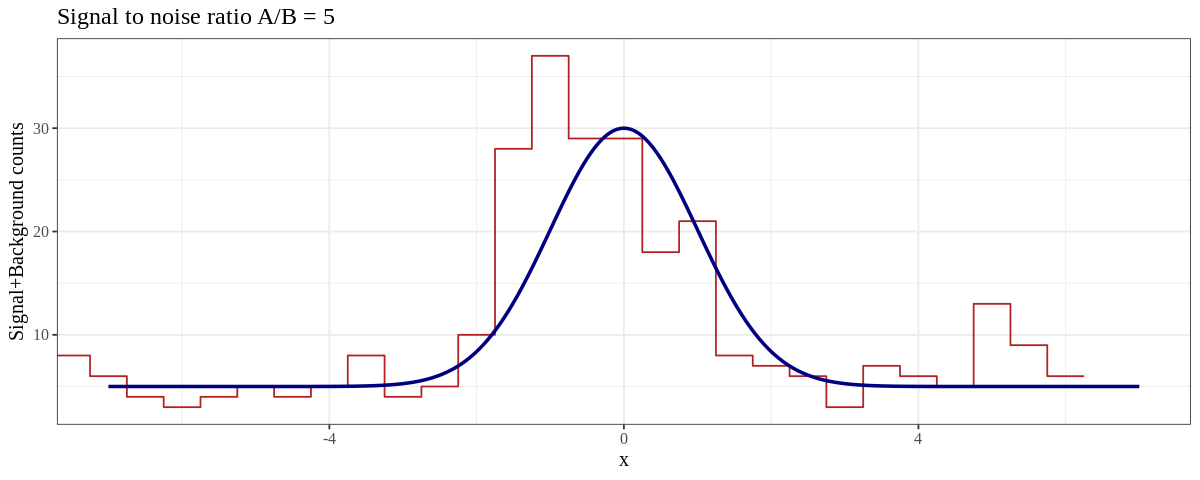

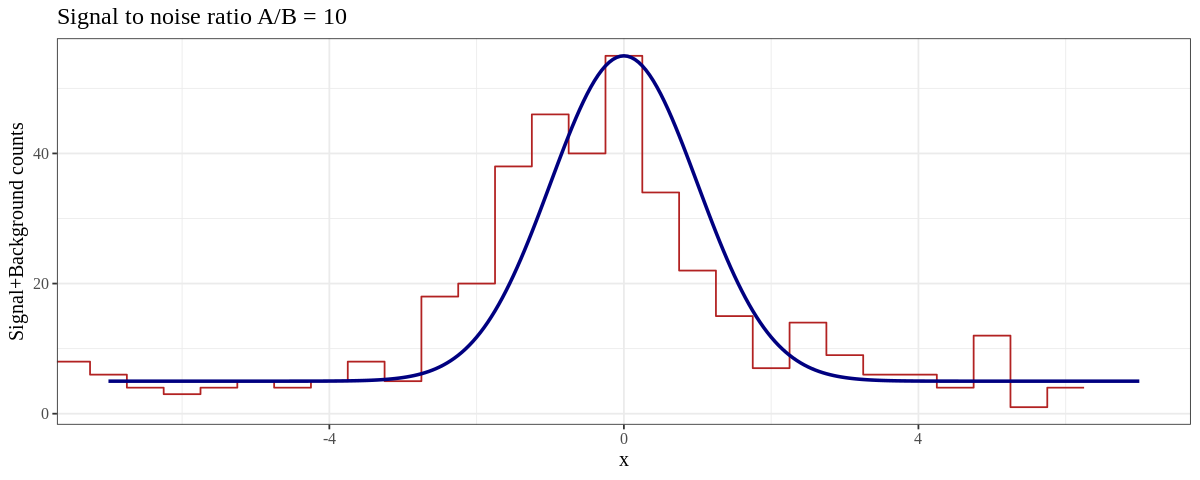

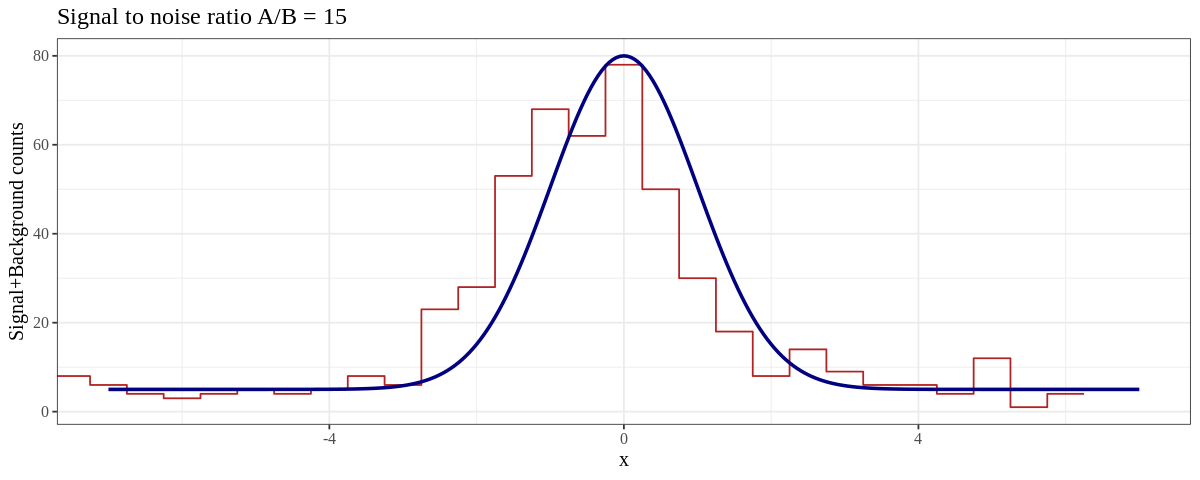

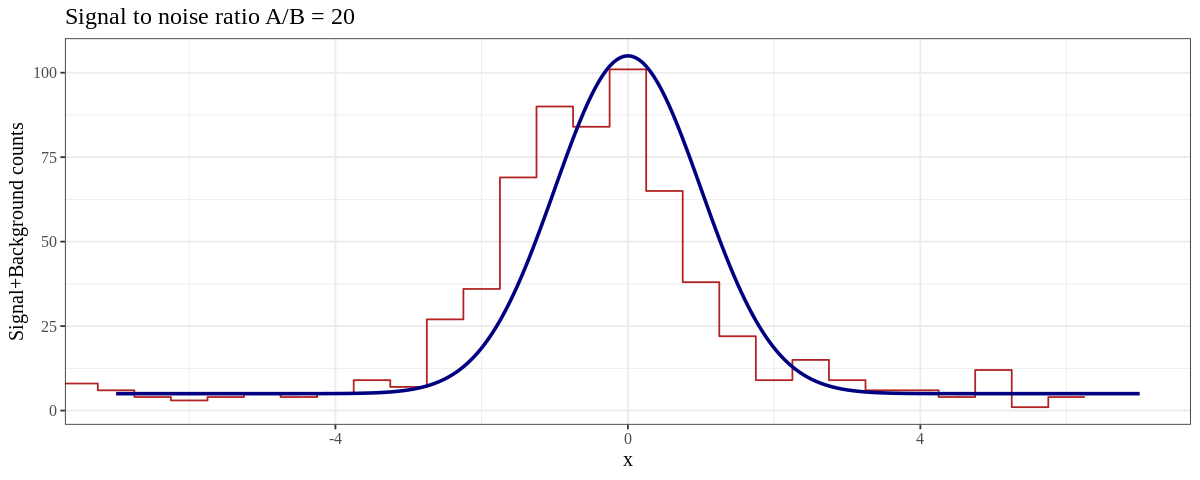

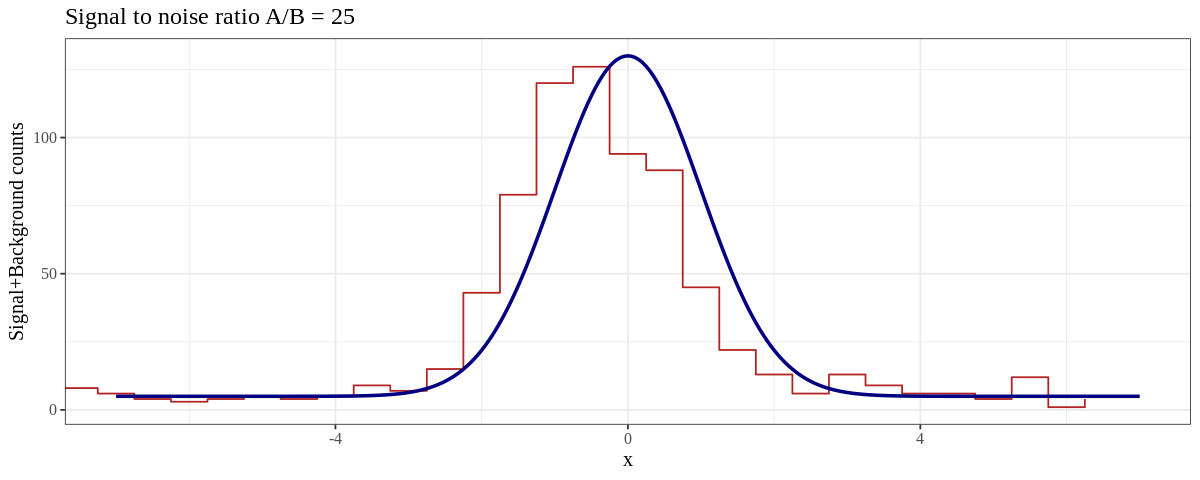

In [23]:
for (A.true in As.true){
    snr <- A.true / B.true
    
    set.seed(2027650)
    xdata  <- seq(from=-7*w, to=7*w, by=0.5*w)
    s.true <- signal(xdata , A.true , B.true , x0, w, dt)
    ddata  <- rpois(length(s.true), s.true)
    
    xplot <- seq(from=min(xdata), to=max(xdata), by=0.05*w)
    splot <- signal(xplot , A.true , B.true , x0, w, dt)
    xdata.off <- xdata - 0.25*r

    curve <- data.table(xplot, splot); sbcounts <- data.table(xdata.off, ddata)
    
    print(ggplot(data=sbcounts, aes(x=xdata.off, y=ddata, group=1)) + geom_step(color='firebrick') +
    geom_line(data=curve, aes(x=xplot, y=splot, group=1), color='navy', size=1) +
    coord_cartesian(xlim=range(xplot), ylim=range(c(splot, ddata))) +
    labs(title=paste('Signal to noise ratio A/B =',snr), x='x', y='Signal+Background counts'))
}

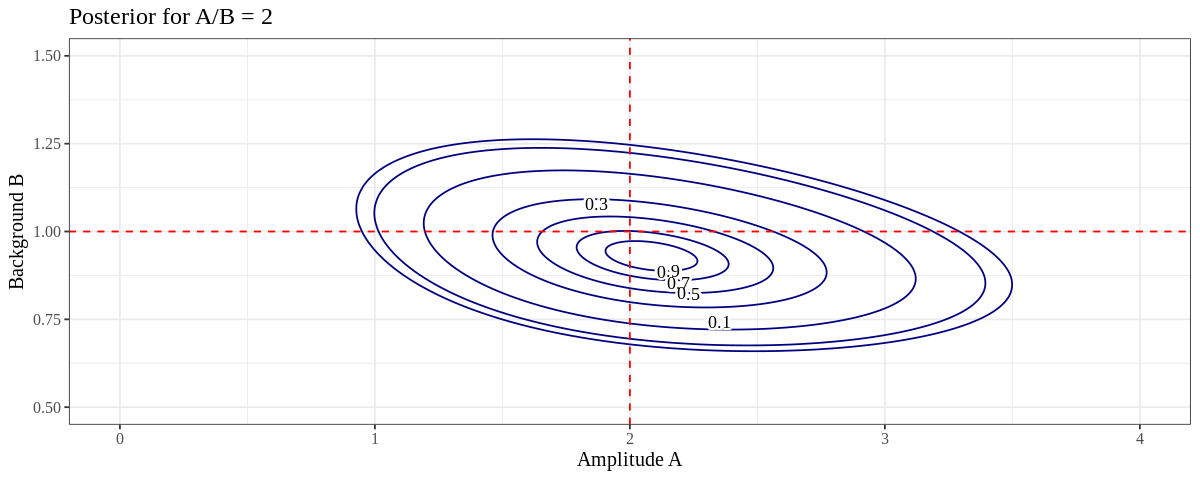

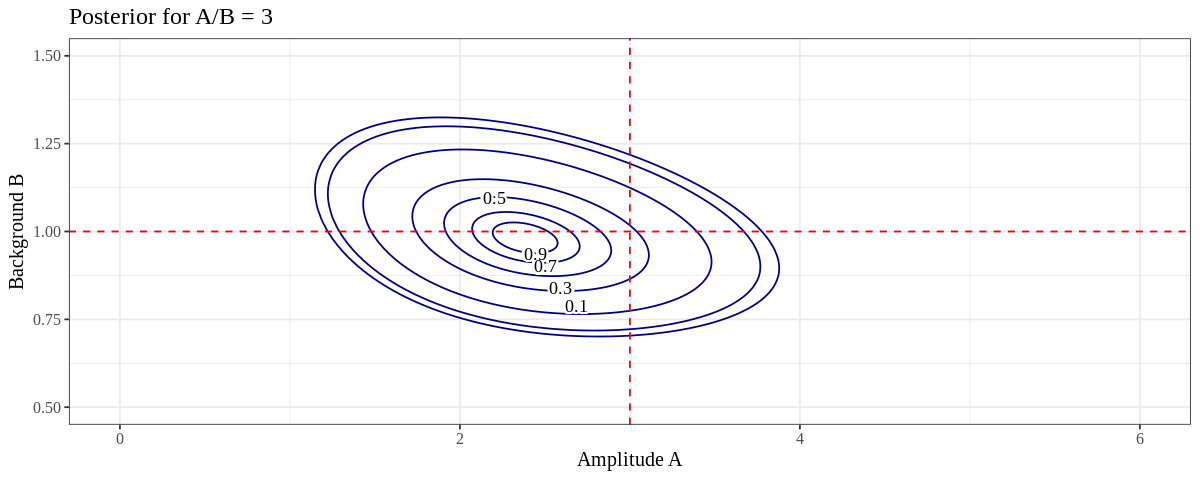

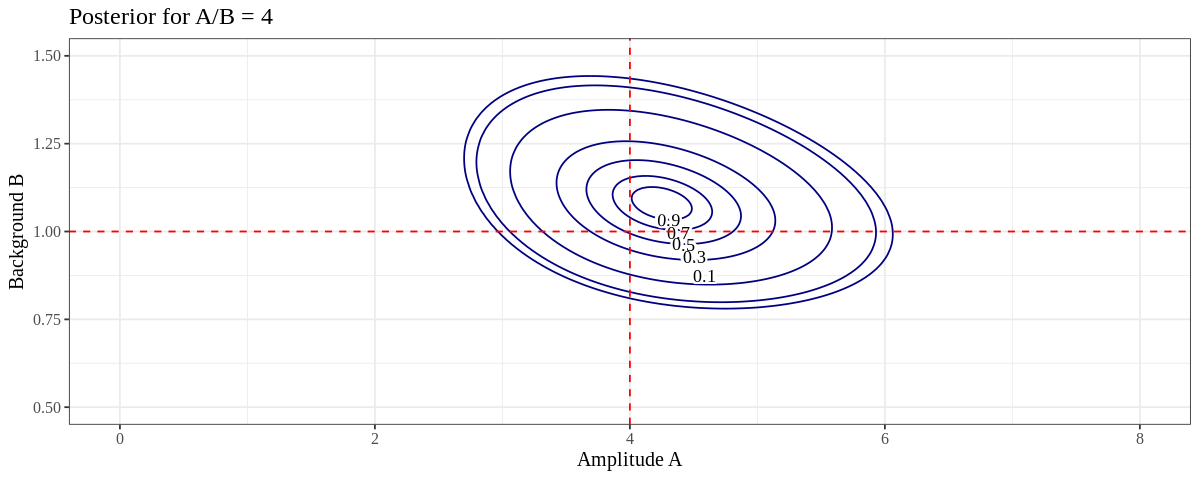

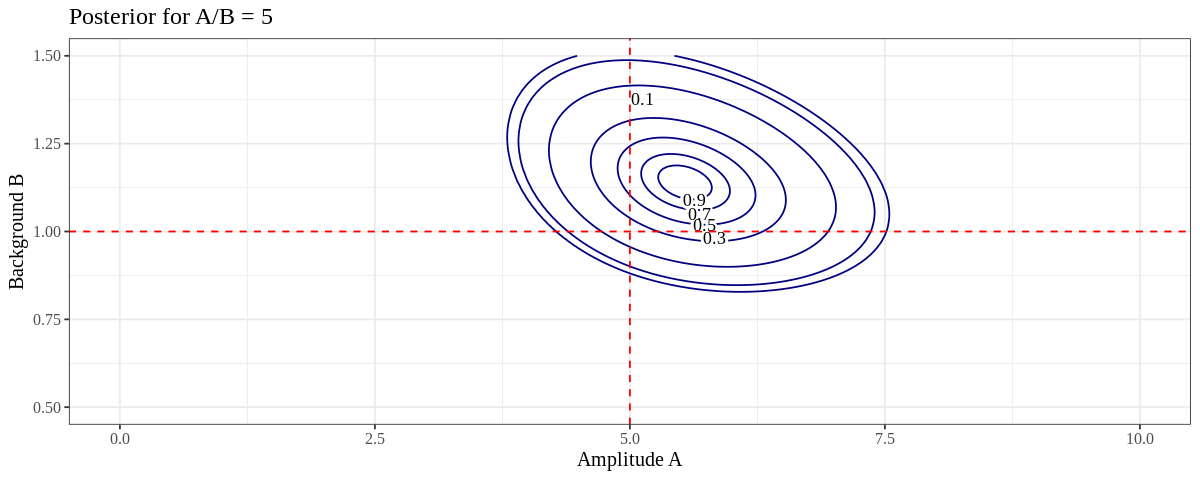

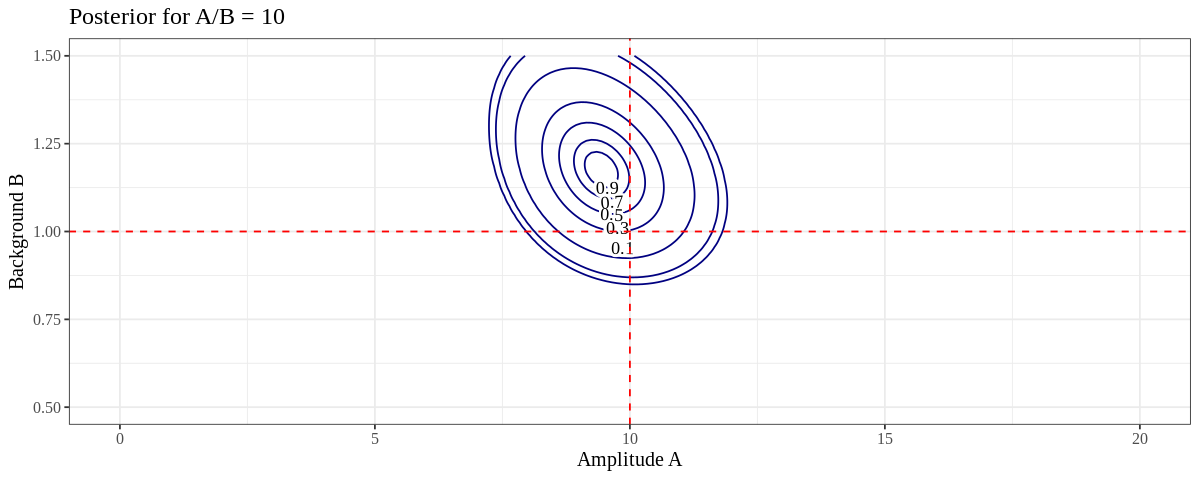

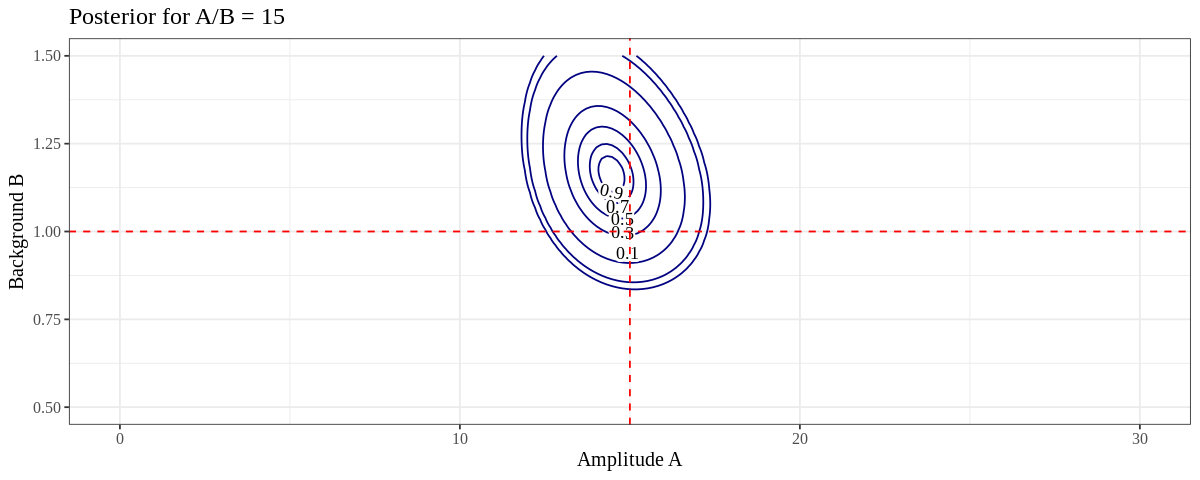

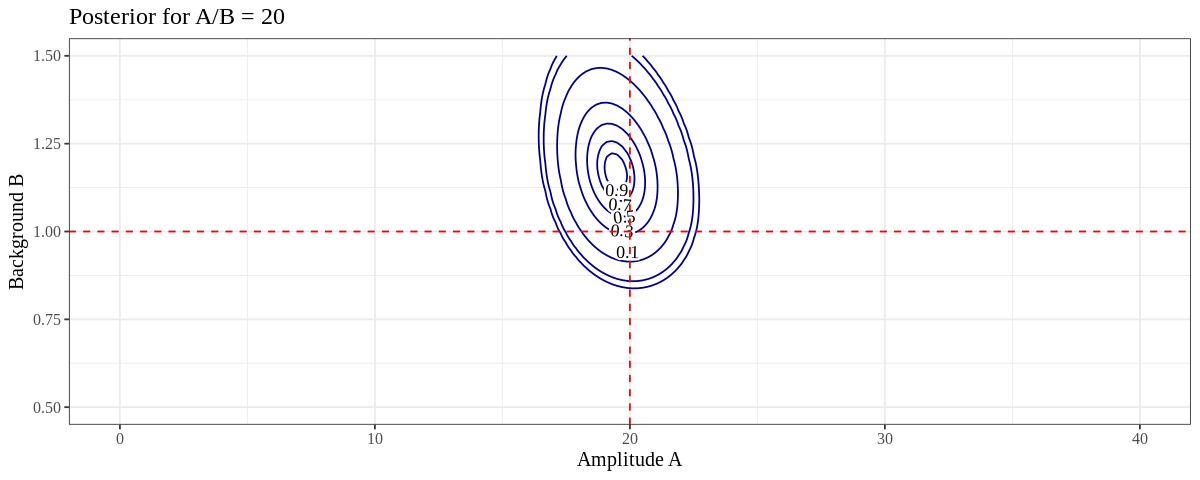

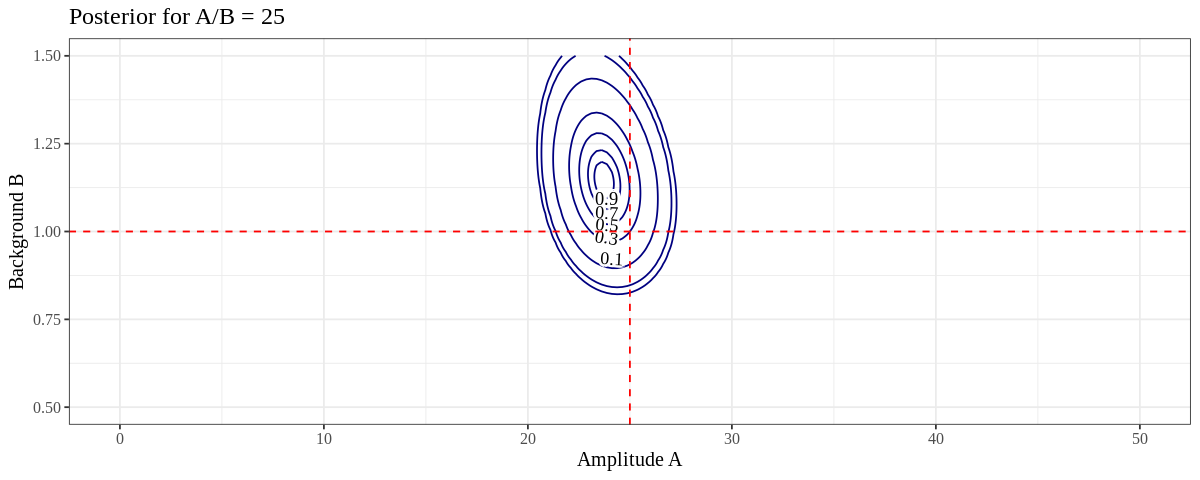

In [24]:
for (A.true in As.true){
    A   <- seq(0.0, 2*A.true, length.out=Nsamp)
    B   <- seq(0.5, 1.5, length.out=Nsamp)
    snr <- A.true / B.true
    
    set.seed(2027650)
    xdata  <- seq(from=-7*w, to=7*w, by=0.5*w)
    s.true <- signal(xdata , A.true, B.true , x0, w, dt)
    ddata  <- rpois(length(s.true), s.true)
    
    # Compute log unnormalized posterior , z = ln P*(a,b|D), on a regular grid
    z <- matrix(data=NA , nrow=length(A), ncol=length(B))
    for(j in 1:length(A)) {
        for(k in 1:length(B)) {
            z[j,k] <- log.post(ddata, xdata, A[j], B[k], x0, w, dt)
        }
    }
    z <- z - max(z) # set maximum to zero
    
    rownames(z) <- A; colnames(z) <- B
    posterior.2d <- melt(exp(z)); names(posterior.2d) <- c('A','B','exp.z')
    breaks <- c(0.005, 0.01, 0.05, 0.25, 0.5, 0.75, 0.9, 1.0)
    
    # Plot unnormalized 2D posterior as contours
    print(ggplot(posterior.2d, aes(x = A, y = B, z = exp.z)) +
          geom_contour(color='navy', breaks=breaks) +
          metR::geom_text_contour(stroke=.2, family='Times New Roman') +
          coord_cartesian(xlim=c(min(A),max(A)), ylim=c(min(B),max(B))) +
          geom_vline(xintercept=A.true, linetype='dashed', col='red', size=0.5) +
          geom_hline(yintercept=B.true, linetype='dashed', col='red', size=0.5) +
          labs(title=paste('Posterior for A/B =', snr), x='Amplitude A', y='Background B'))
}

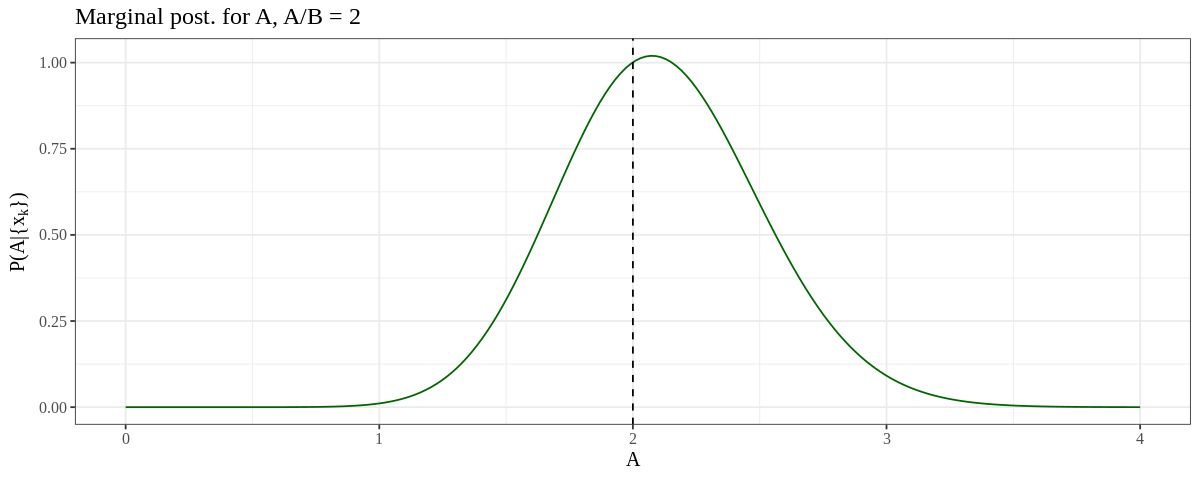

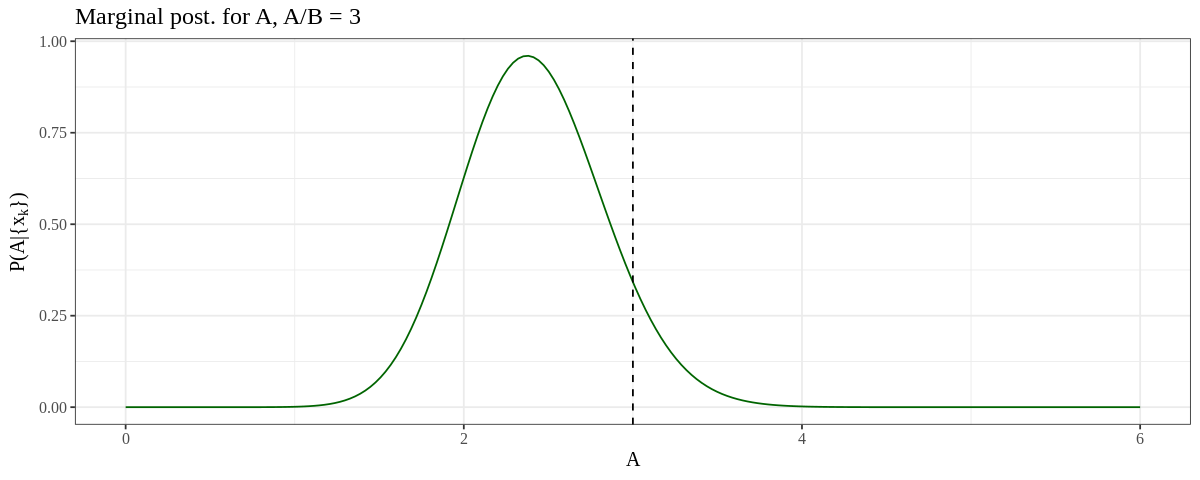

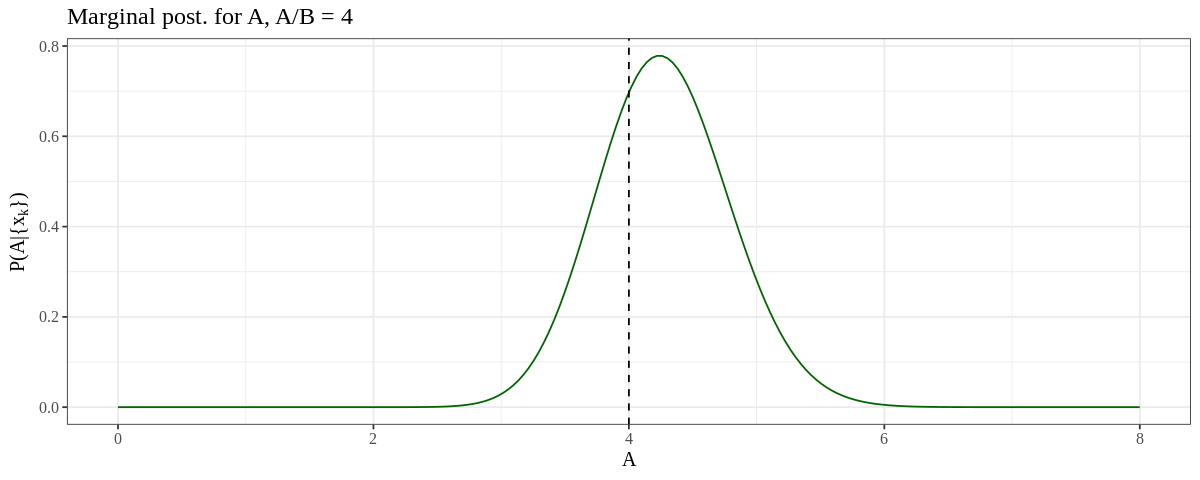

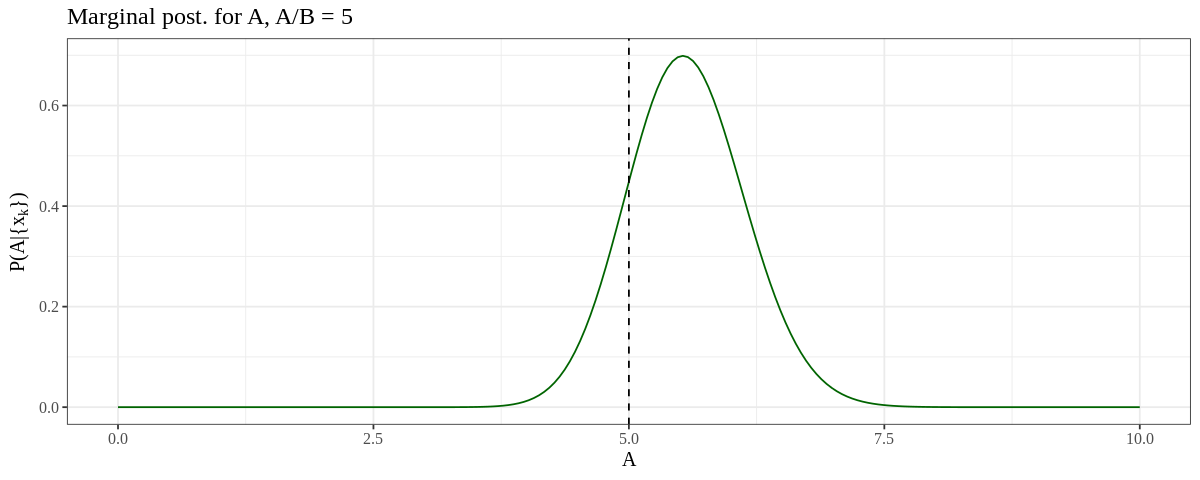

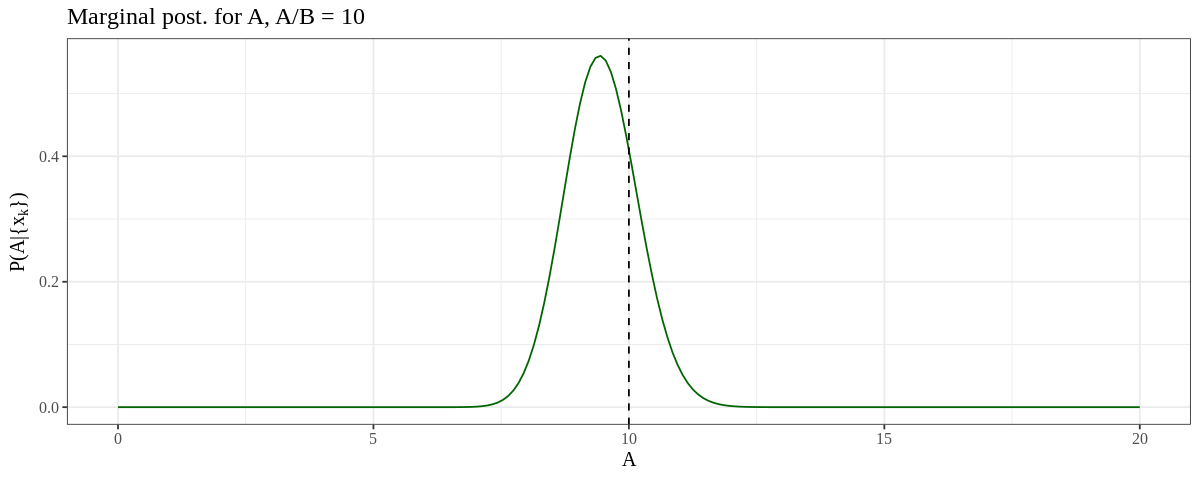

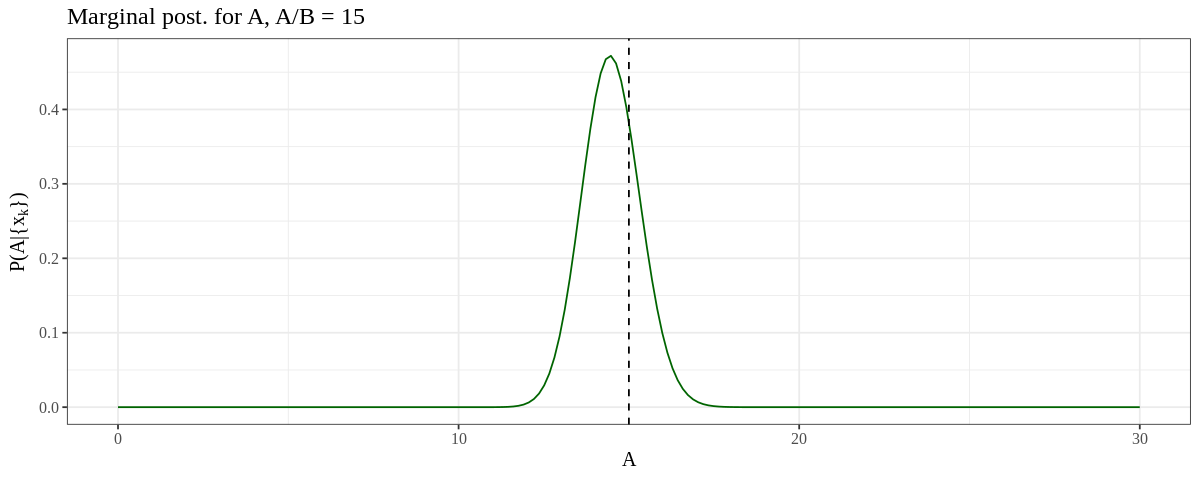

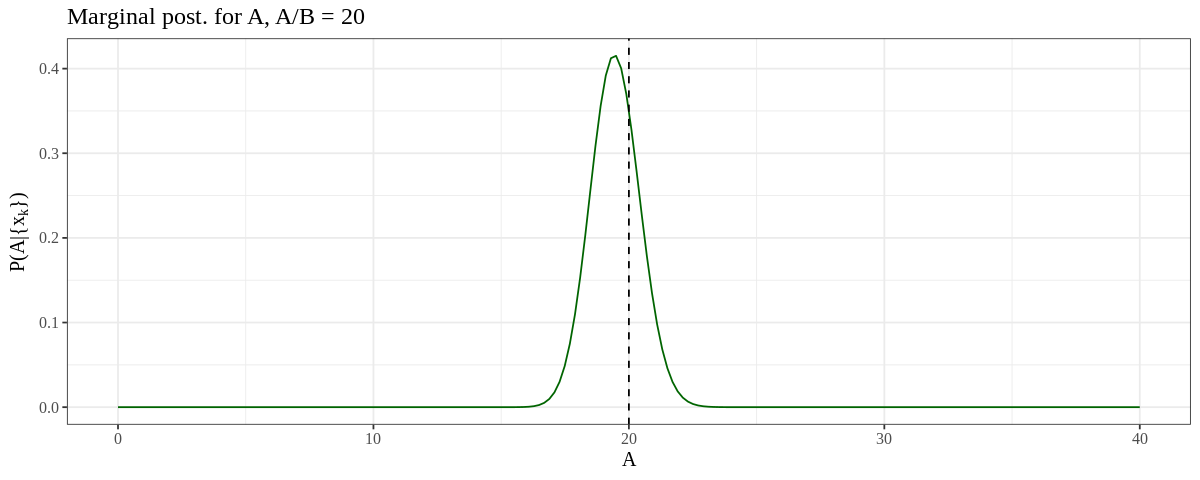

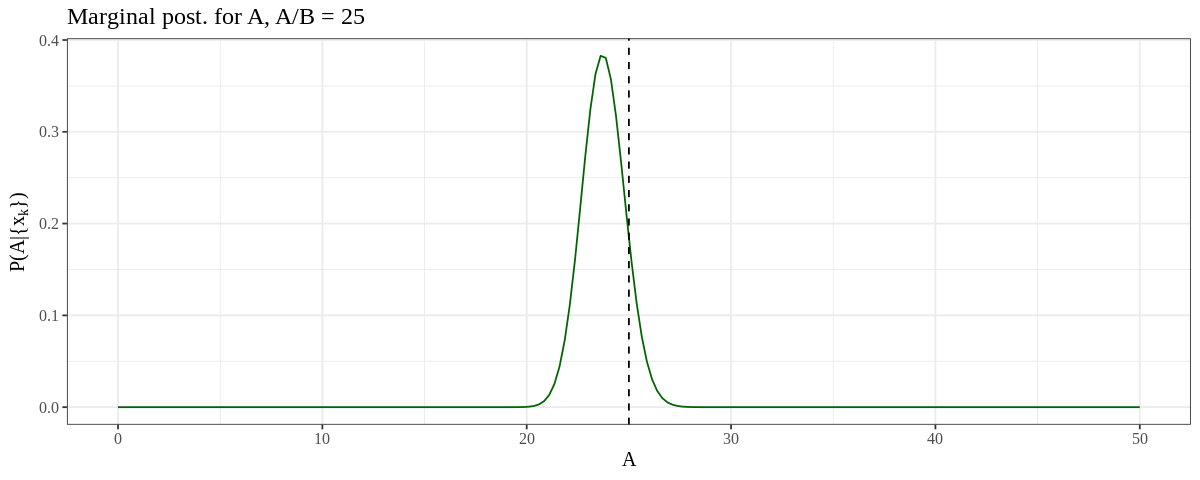

In [25]:
for (A.true in As.true){
    A   <- seq(0.0, 2*A.true, length.out=Nsamp)
    B   <- seq(0.5, 1.5, length.out=Nsamp)
    dA  <- (max(A)-min(A))/Nsamp
    snr <- A.true / B.true
    
    set.seed(2027650)
    xdata  <- seq(from=-7*w, to=7*w, by=0.5*w)
    s.true <- signal(xdata , A.true, B.true , x0, w, dt)
    ddata  <- rpois(length(s.true), s.true)
    
    # Compute log unnormalized posterior , z = ln P*(a,b|D), on a regular grid
    z <- matrix(data=NA , nrow=length(A), ncol=length(B))
    for(j in 1:length(A)) {
        for(k in 1:length(B)) {
            z[j,k] <- log.post(ddata, xdata, A[j], B[k], x0, w, dt)
        }
    }
    z <- z - max(z) # set maximum to zero
    
    z.a    <- apply(exp(z), 1, sum)
    z.a.n  <- z.a/(dA*sum(z.a))
    df.z.a <- data.table(A, z.a.n)
    
    # Plot normalized marginal posterior for A
    print(ggplot(df.z.a, aes(A, z.a.n)) + geom_line(size=.5, col='darkgreen') +
          geom_vline(xintercept=A.true, linetype='dashed', col ='black', size=0.5) +
          labs(title=paste('Marginal post. for A, A/B =', snr), x='A', y=TeX('$P(A | \\{x_k\\})$')))
}

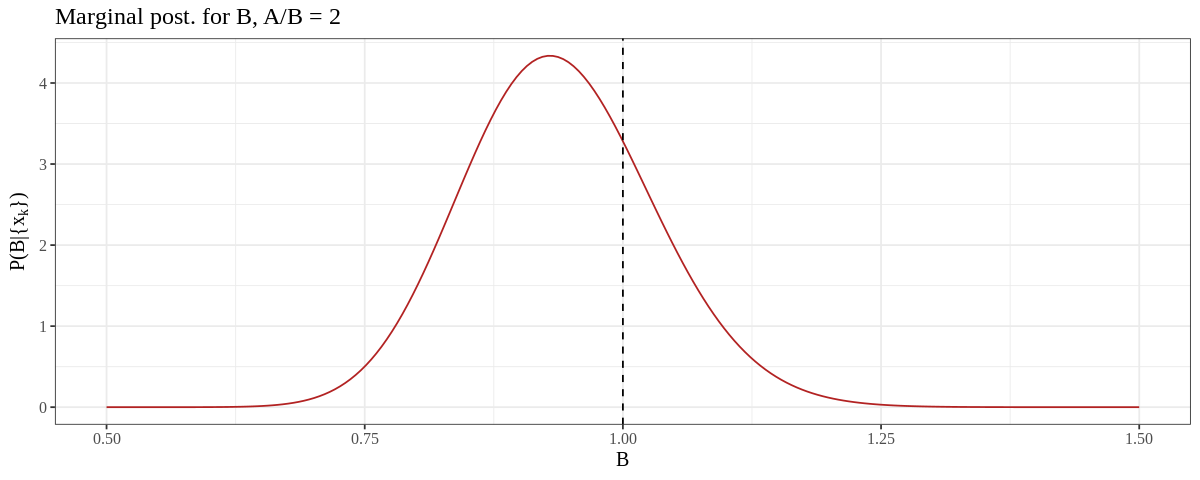

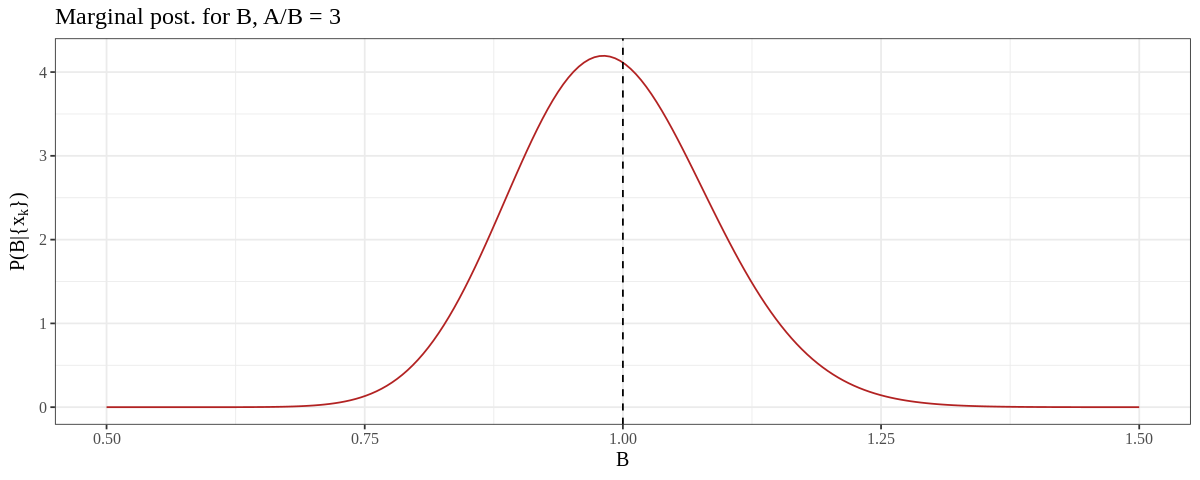

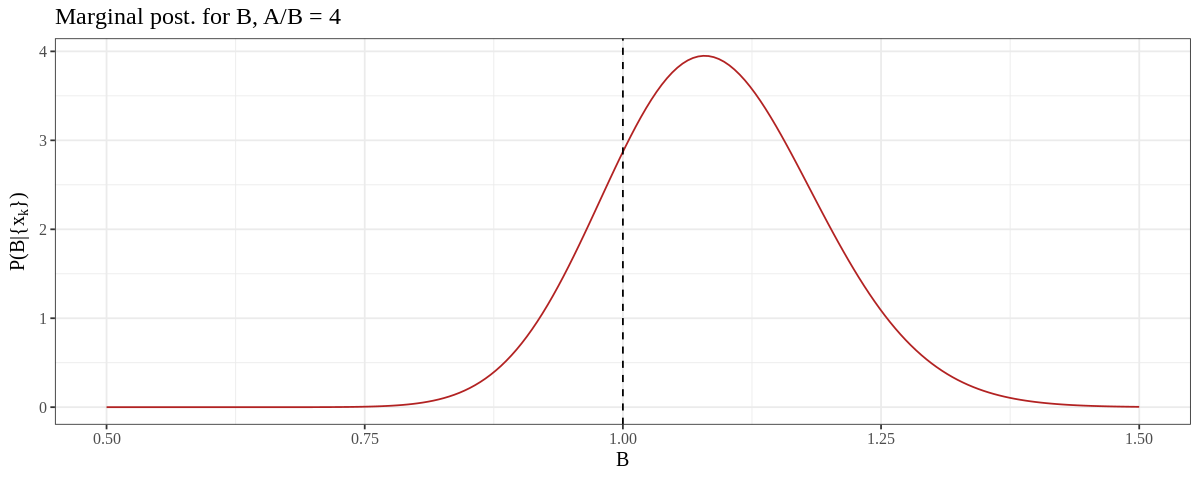

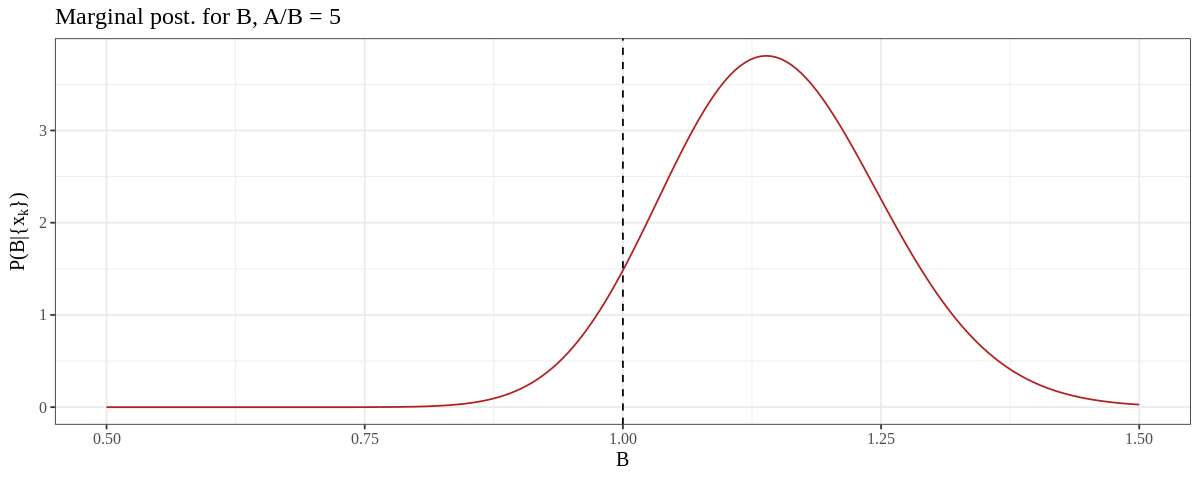

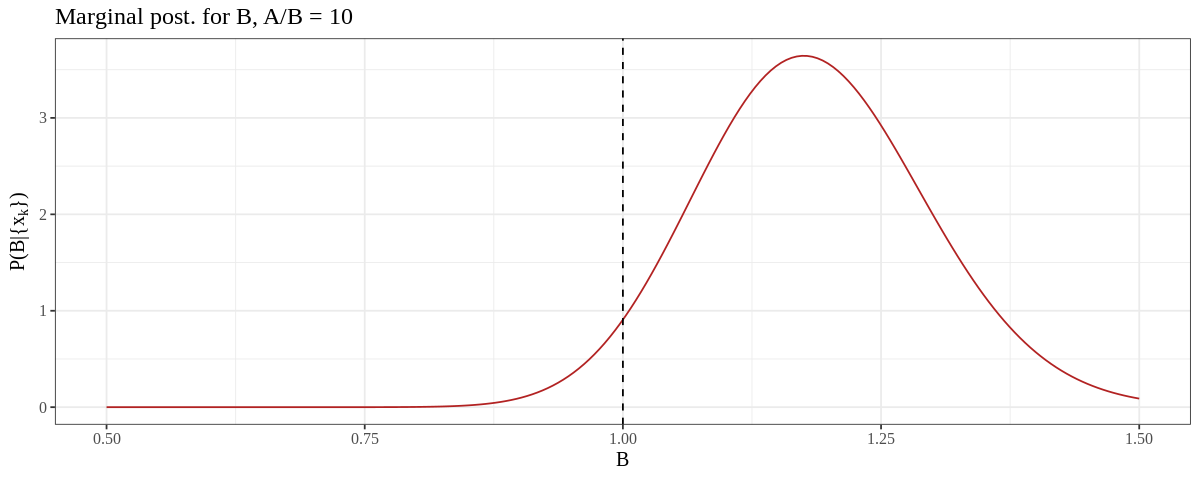

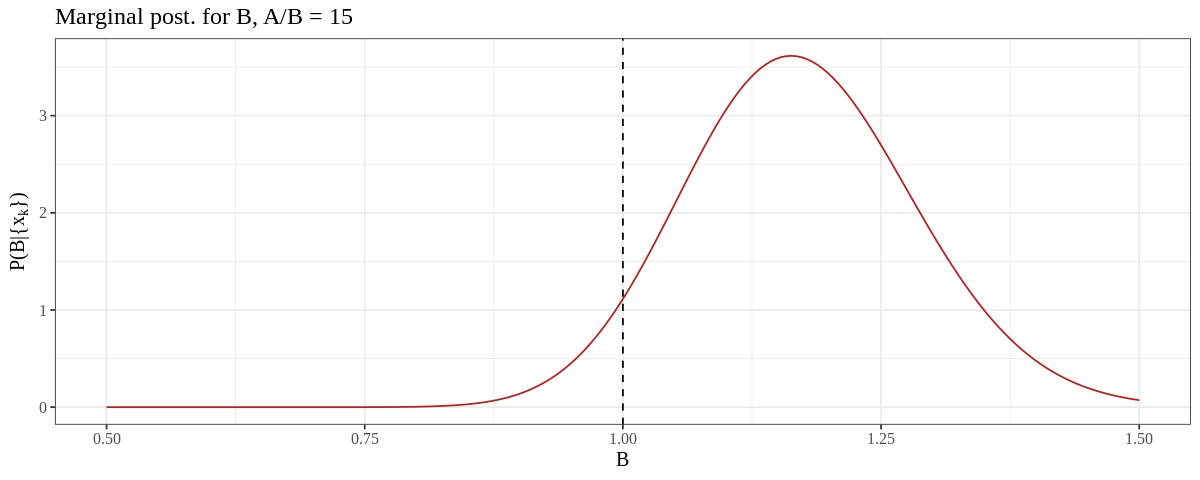

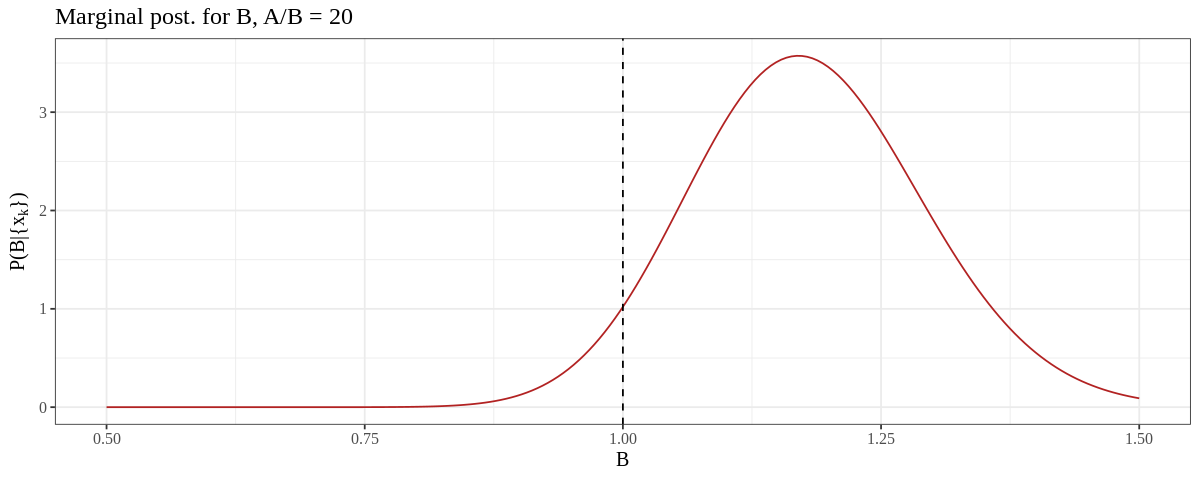

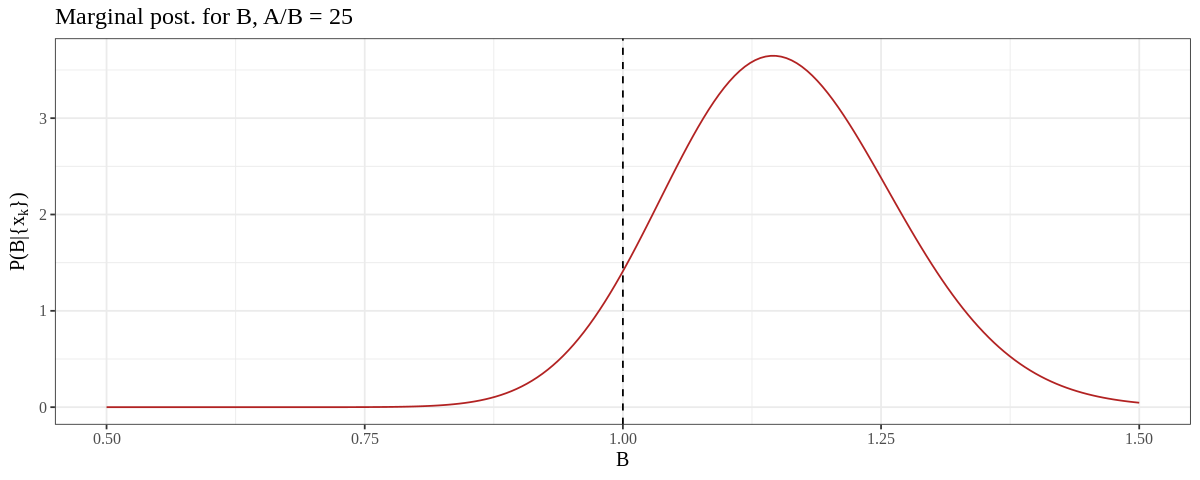

In [26]:
for (A.true in As.true) {
    A   <- seq(0.0, 2*A.true, length.out=Nsamp)
    B   <- seq(0.5, 1.5, length.out=Nsamp)
    dB  <- (max(B)-min(B))/Nsamp
    snr <- A.true / B.true
    
    set.seed(2027650)
    xdata  <- seq(from=-7*w, to=7*w, by=0.5*w)
    s.true <- signal(xdata , A.true, B.true , x0, w, dt)
    ddata  <- rpois(length(s.true), s.true)
    
    # Compute log unnormalized posterior , z = ln P*(a,b|D), on a regular grid
    z <- matrix(data=NA , nrow=length(A), ncol=length(B))
    for(j in 1:length(A)) {
        for(k in 1:length(B)) {
            z[j,k] <- log.post(ddata, xdata, A[j], B[k], x0, w, dt)
        }
    }
    z <- z - max(z) # set maximum to zero
    
    z.b    <- apply(exp(z), 2, sum)
    z.b.n  <- z.b/(dB*sum(z.b))
    df.z.b <- data.table(B, z.b.n)
    
    # Plot normalized marginal posterior for B
    print(ggplot(df.z.b, aes(B, z.b.n)) + geom_line(size=.5, col='firebrick') +
          geom_vline(xintercept=B.true, linetype='dashed', col='black', size=0.5) +
          labs(title=paste('Marginal post. for B, A/B =', snr), x='B', y=TeX('$P(B | \\{x_k\\})$')))
}

The marginalization for $A$ and $B$ produces different results depending on the ratio $R = A/B$: for high values of $R$ the curve for $A$ becomes more and more peaked on the true value while for $B$ no significant change can be observed. This follows the expected behaviour since a higher ratio defines a clearer signal while the amplitude of the background is kept constant.